# Objetivo iteracion

Revisar los datos para que el RMSE en train sea menor que en validation.
Introduccion timeseries split. Problema solucionado.

<a id='imports_notebook'></a>
# Imports del notebook
[Volver al índice](#index)

En este apartado hacemos los principales imports del notebook.<br>
Sobre todo vamos a trabajar con **numpy**, **pandas**, **statsmodels** y **XGBoost**.

In [ ]:
!pip install statsmodels

In [ ]:
# Installa una versione specifica di XGBoost
!pip install xgboost==2.0.3

# Verifica l'installazione della versione desiderata
import xgboost as xgb
print("Nuova versione di XGBoost:", xgb.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.7 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.1
    Uninstalling xgboost-2.1.1:
      Successfully uninstalled xgboost-2.1.1
Nuova versione di XGBoost: 2.0.3


In [ ]:
import pickle
import os

from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit

from sklearn import set_config

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

set_config(transform_output = "pandas")

pd.set_option('display.max_columns',None)

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

from datetime import datetime, timedelta

In [ ]:
print("Working with these versions of libraries\n")
print("-"*50)
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"XGBoost version {xgb.__version__}")

Working with these versions of libraries

--------------------------------------------------
Numpy version 1.26.4
Pandas version 2.1.4
XGBoost version 2.0.3


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Loading

El dataset que cargo (weekly_df_extended_encoded) es el dataframe agrupado por semana y con las columnas categoricas ya encodeadas. Este dataset ya incluye las 4 semanas que tenemos que predecir.

Despues voy a crear 4 dataframe distintos, uno para cada semana a predecir en el futuro. Entrenare 4 modelos diferentes, uno por cada semana a predecir.

## df1

In [ ]:
# dataset con encoding que usarè de base para el modelo de forecasting
df1 = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Data/weekly_df_extended_encoded')

In [ ]:
df1.columns

Index(['id', 'yearweek', 'item', 'category', 'department', 'store_code',
       'region', 'units_sold', 'revenue', 'price_per_unit', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year'],
      dtype='object')

## weekly_df_no_enc

In [ ]:
# dataset sin encoding que solo usarè para construir el datset con los resultados finales (predicciones)
weekly_df_no_enc = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Data/weekly_df_extended')

In [ ]:
weekly_df_no_enc.columns

Index(['id', 'yearweek', 'date', 'item', 'category', 'department',
       'store_code', 'store', 'region', 'units_sold', 'revenue',
       'price_per_unit', 'event_week_flag', 'product_cluster', 'store_cluster',
       'week_of_year', 'month', 'quarter', 'year'],
      dtype='object')

In [ ]:
weekly_df_no_enc.drop('revenue',axis=1,inplace=True)

# EDA

## REPORT

In [ ]:
def report_df(df, verbose=False):
    """
    Genera un informe simple para el DataFrame proporcionado.

    """
    # Identificamos dtypes
    object_cols = df.select_dtypes(include=['object']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    bool_cols = df.select_dtypes(include=['bool']).columns
    datetime_cols = df.select_dtypes(include=['datetime64']).columns

    # DataFrame shape
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")

    # Detailed report by data type
    print(f"\n{'-'*80}\nColumns of type Object ({len(object_cols)}):\n{list(object_cols)}")
    print(f"\n{'-'*80}\nColumns of type Int ({len(int_cols)}):\n{list(int_cols)}")
    print(f"\n{'-'*80}\nColumns of type Float ({len(float_cols)}):\n{list(float_cols)}")
    print(f"\n{'-'*80}\nColumns of type Boolean ({len(bool_cols)}):\n{list(bool_cols)}")
    print(f"\n{'-'*80}\nColumns of type Datetime ({len(datetime_cols)}):\n{list(datetime_cols)}\n")

    print('-'*80)

    # Nulos
    total_nulls = df.isnull().sum().sum()
    print(f"Total missing values: {total_nulls}")

    # Duplicados
    total_duplicates = df.duplicated().sum()
    print(f"Total duplicate rows: {total_duplicates}")

    # Rango de fechas
    MIN_yearweek = df["yearweek"].min()
    MAX_yearweek = df["yearweek"].max()
    print(f"Min yearweek is {MIN_yearweek}\nMax yearweek is {MAX_yearweek}")

    print(f'Number of ids: {df["id"].nunique()}')
    print(f'Number of categories: {df["category"].nunique()}')
    print(f'Number of departments: {df["department"].nunique()}')
    print(f'Number of store_codes: {df["store_code"].nunique()}')
    print(f'Number of regions: {df["region"].nunique()}')
    print(f'Number of product_clusters: {df["product_cluster"].nunique()}')
    print(f'Number of store_clusters: {df["store_cluster"].nunique()}')

In [ ]:
report_df(df1)

## Outliers

### Units_sold

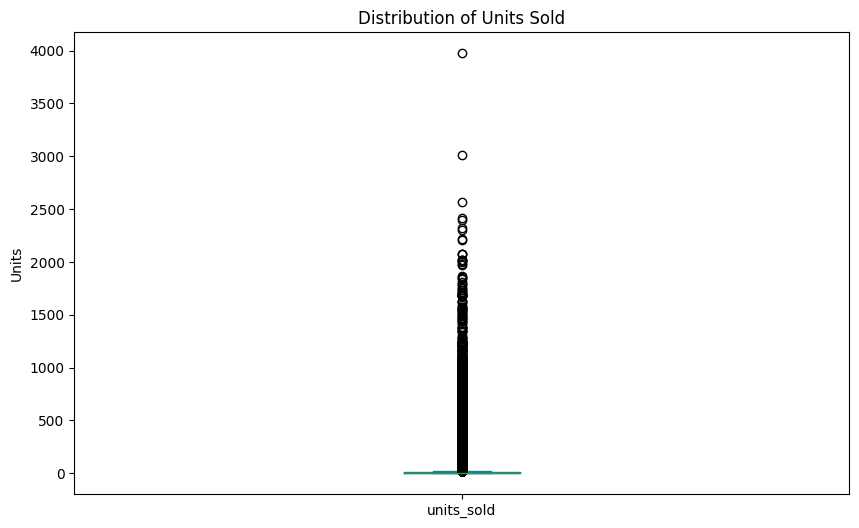

In [ ]:
df1['units_sold'].plot(kind='box', figsize=(10, 6))
plt.title('Distribution of Units Sold')
plt.ylabel('Units')
plt.show()

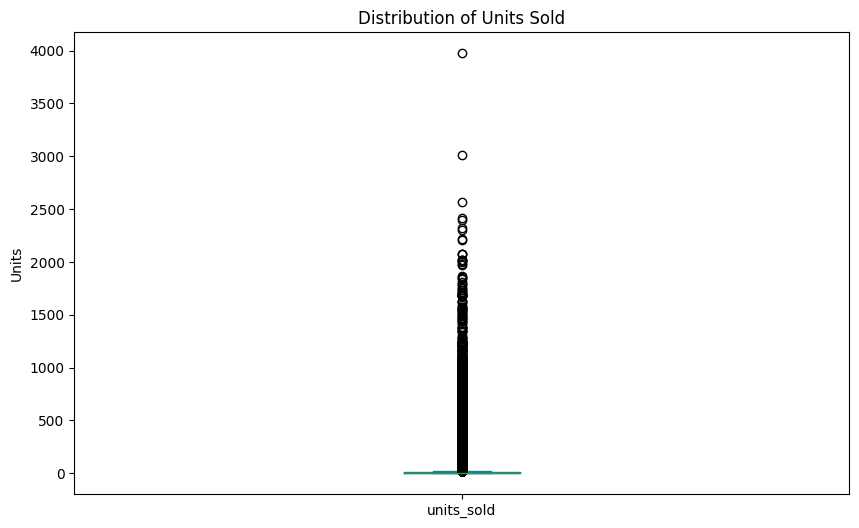

In [ ]:
weekly_df_no_enc['units_sold'].plot(kind='box', figsize=(10, 6))
plt.title('Distribution of Units Sold')
plt.ylabel('Units')
plt.show()

Parece haber 3 outliers a partir de los 2500

In [ ]:
df1[df1['units_sold']>2500]

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
6405672,SUPERMARKET_3_090_NYC_3,201152,2312.0,2.0,6.0,5.0,1.0,2568.0,3944.448,1.536,1,1,1,52,12,4,2011
6405759,SUPERMARKET_3_090_NYC_3,201335,2312.0,2.0,6.0,5.0,1.0,3016.0,3619.200,1.200,0,1,1,35,8,3,2013
6405761,SUPERMARKET_3_090_NYC_3,201337,2312.0,2.0,6.0,5.0,1.0,3976.0,4771.200,1.200,0,1,1,37,9,3,2013


In [ ]:
weekly_df_no_enc[weekly_df_no_enc['units_sold']>2500]

,id,yearweek,date,item,category,department,store_code,store,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
6405672,SUPERMARKET_3_090_NYC_3,201152,2012-01-01,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,2568.0,1.536,1,1,1,52,12,4,2011
6405759,SUPERMARKET_3_090_NYC_3,201335,2013-09-01,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,3016.0,1.200,0,1,1,35,8,3,2013
6405761,SUPERMARKET_3_090_NYC_3,201337,2013-09-15,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,3976.0,1.200,0,1,1,37,9,3,2013


### price_per_unit

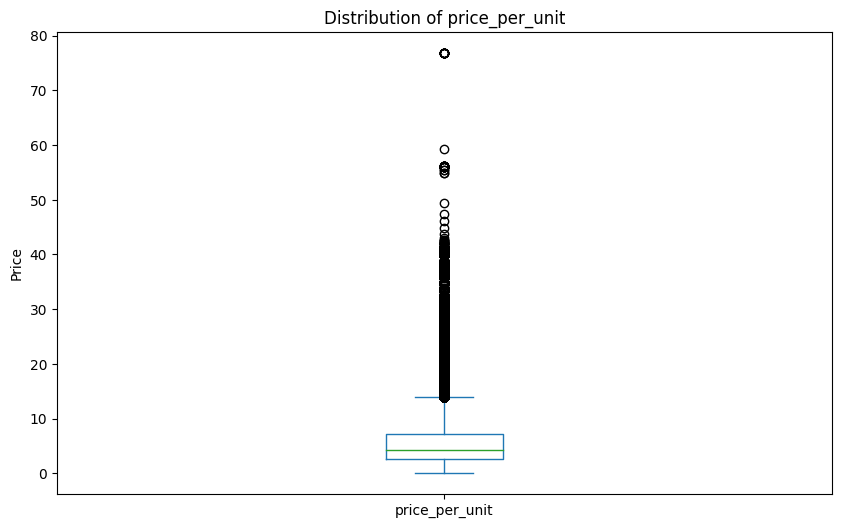

In [ ]:
df1['price_per_unit'].plot(kind='box', figsize=(10, 6))
plt.title('Distribution of price_per_unit')
plt.ylabel('Price')
plt.show()

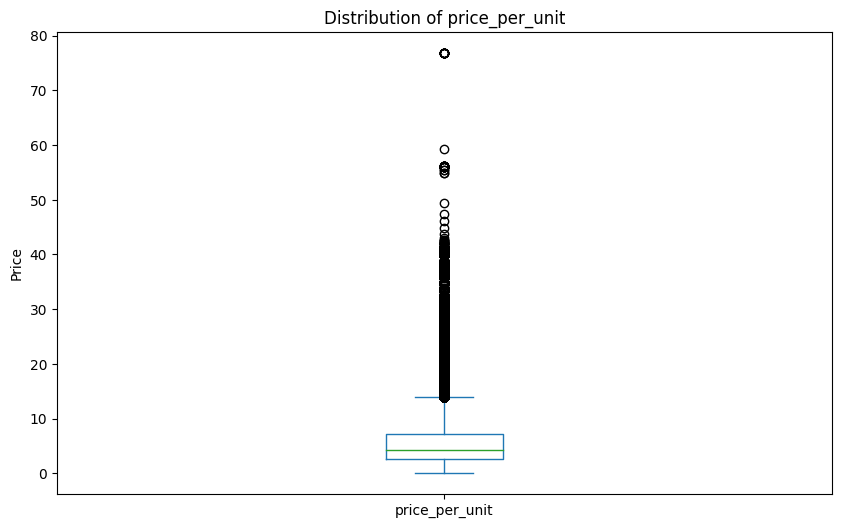

In [ ]:
weekly_df_no_enc['price_per_unit'].plot(kind='box', figsize=(10, 6))
plt.title('Distribution of price_per_unit')
plt.ylabel('Price')
plt.show()

Parce haber 2 outliers a partir de 60 unidades

In [ ]:
df1[df1['price_per_unit'] > 60]

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
4154534,HOME_&_GARDEN_2_406_PHI_2,201241,1499.0,1.0,3.0,8.0,2.0,1.0,76.825,76.825,0,4,2,41,10,4,2012
4154535,HOME_&_GARDEN_2_406_PHI_2,201242,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,0,4,2,42,10,4,2012
4154536,HOME_&_GARDEN_2_406_PHI_2,201243,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,0,4,2,43,10,4,2012
4154537,HOME_&_GARDEN_2_406_PHI_2,201244,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,1,4,2,44,10,4,2012
4154538,HOME_&_GARDEN_2_406_PHI_2,201245,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,0,4,2,45,11,4,2012
4154539,HOME_&_GARDEN_2_406_PHI_2,201246,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,0,4,2,46,11,4,2012
4154540,HOME_&_GARDEN_2_406_PHI_2,201247,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,1,4,2,47,11,4,2012
4154541,HOME_&_GARDEN_2_406_PHI_2,201248,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,0,4,2,48,11,4,2012
4154542,HOME_&_GARDEN_2_406_PHI_2,201249,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,0,4,2,49,12,4,2012
4154543,HOME_&_GARDEN_2_406_PHI_2,201250,1499.0,1.0,3.0,8.0,2.0,0.0,0.000,76.825,0,4,2,50,12,4,2012


In [ ]:
weekly_df_no_enc[weekly_df_no_enc['price_per_unit'] > 60]

,id,yearweek,date,item,category,department,store_code,store,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
4154534,HOME_&_GARDEN_2_406_PHI_2,201241,2012-10-14,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,1.0,76.825,0,4,2,41,10,4,2012
4154535,HOME_&_GARDEN_2_406_PHI_2,201242,2012-10-21,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,0,4,2,42,10,4,2012
4154536,HOME_&_GARDEN_2_406_PHI_2,201243,2012-10-28,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,0,4,2,43,10,4,2012
4154537,HOME_&_GARDEN_2_406_PHI_2,201244,2012-11-04,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,1,4,2,44,10,4,2012
4154538,HOME_&_GARDEN_2_406_PHI_2,201245,2012-11-11,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,0,4,2,45,11,4,2012
4154539,HOME_&_GARDEN_2_406_PHI_2,201246,2012-11-18,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,0,4,2,46,11,4,2012
4154540,HOME_&_GARDEN_2_406_PHI_2,201247,2012-11-25,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,1,4,2,47,11,4,2012
4154541,HOME_&_GARDEN_2_406_PHI_2,201248,2012-12-02,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,0,4,2,48,11,4,2012
4154542,HOME_&_GARDEN_2_406_PHI_2,201249,2012-12-09,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,0,4,2,49,12,4,2012
4154543,HOME_&_GARDEN_2_406_PHI_2,201250,2012-12-16,HOME_&_GARDEN_2_406,HOME_&_GARDEN,HOME_&_GARDEN_2,PHI_2,Yorktown,Philadelphia,0.0,76.825,0,4,2,50,12,4,2012


In [ ]:
df1[df1['id'] == 'HOME_&_GARDEN_2_406_PHI_2'].groupby('year')['price_per_unit'].max()

,price_per_unit
year,
2011,24.846429
2012,76.825000
2013,15.575000
2014,15.575000
2015,29.932143
2016,15.575000


In [ ]:
weekly_df_no_enc[weekly_df_no_enc['id'] == 'HOME_&_GARDEN_2_406_PHI_2'].groupby('year')['price_per_unit'].max()

,price_per_unit
year,
2011,24.846429
2012,76.825000
2013,15.575000
2014,15.575000
2015,29.932143
2016,15.575000


In [ ]:
df1[(df1['id'] == 'HOME_&_GARDEN_2_406_PHI_2') & (df1['year'] == 2012)].groupby('month')['price_per_unit'].max()

,price_per_unit
month,
1,15.587500
2,26.844643
3,54.987500
4,30.875000
5,30.875000
6,30.875000
7,15.587500
8,15.587500
9,15.587500


In [ ]:
df1[(df1['id'] == 'HOME_&_GARDEN_2_406_PHI_2') & (df1['year'] == 2013)].groupby('month')['price_per_unit'].max()

,price_per_unit
month,
1,15.575
2,15.575
3,15.575
4,15.575
5,15.575
6,15.575
7,15.575
8,15.575
9,15.575


In [ ]:
price_corrected = df1[(df1['id'] == 'HOME_&_GARDEN_2_406_PHI_2') & (df1['year'] == 2013)]['price_per_unit'].mean()
price_corrected

15.575000000000005

In [ ]:
price_corrected_2 = weekly_df_no_enc[(weekly_df_no_enc['id'] == 'HOME_&_GARDEN_2_406_PHI_2') & (weekly_df_no_enc['year'] == 2013)]['price_per_unit'].mean()
price_corrected_2

15.575000000000005

In [ ]:
df1.loc[df1['price_per_unit'] > 60, 'price_per_unit'] = price_corrected

weekly_df_no_enc.loc[weekly_df_no_enc['price_per_unit'] > 60, 'price_per_unit'] = price_corrected_2

In [ ]:
df1[(df1['price_per_unit'] > 50)]['id'].unique()

array(['HOME_&_GARDEN_2_178_BOS_1', 'HOME_&_GARDEN_2_406_PHI_2',
       'HOME_&_GARDEN_2_466_BOS_1'], dtype=object)

In [ ]:
df1[(df1['price_per_unit'] > 50) & (df1['id'] == 'HOME_&_GARDEN_2_406_PHI_2' )]

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
4154503,HOME_&_GARDEN_2_406_PHI_2,201210,1499.0,1.0,3.0,8.0,2.0,0.0,0.0,54.9875,0,4,2,10,3,1,2012
4154504,HOME_&_GARDEN_2_406_PHI_2,201211,1499.0,1.0,3.0,8.0,2.0,0.0,0.0,54.9875,0,4,2,11,3,1,2012
4154546,HOME_&_GARDEN_2_406_PHI_2,201301,1499.0,1.0,3.0,8.0,2.0,0.0,0.0,59.3250,1,4,2,1,12,4,2012


In [ ]:
df1[(df1['price_per_unit'] > 50) & (df1['id'] == 'HOME_&_GARDEN_2_178_BOS_1' )]

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
3523516,HOME_&_GARDEN_2_178_BOS_1,201229,1272.0,1.0,3.0,0.0,0.0,1.0,55.45,55.45,1,2,1,29,7,3,2012
3523517,HOME_&_GARDEN_2_178_BOS_1,201230,1272.0,1.0,3.0,0.0,0.0,0.0,0.00,55.45,0,2,1,30,7,3,2012


In [ ]:
df1[(df1['price_per_unit'] > 50) & (df1['id'] == 'HOME_&_GARDEN_2_466_BOS_1' )]

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
4318523,HOME_&_GARDEN_2_466_BOS_1,201246,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,0,2,1,46,11,4,2012
4318524,HOME_&_GARDEN_2_466_BOS_1,201247,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,1,2,1,47,11,4,2012
4318525,HOME_&_GARDEN_2_466_BOS_1,201248,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,0,2,1,48,11,4,2012
4318526,HOME_&_GARDEN_2_466_BOS_1,201249,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,0,2,1,49,12,4,2012
4318527,HOME_&_GARDEN_2_466_BOS_1,201250,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,0,2,1,50,12,4,2012
4318528,HOME_&_GARDEN_2_466_BOS_1,201251,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,0,2,1,51,12,4,2012
4318529,HOME_&_GARDEN_2_466_BOS_1,201252,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,1,2,1,52,12,4,2012
4318530,HOME_&_GARDEN_2_466_BOS_1,201301,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,1,2,1,1,12,4,2012
4318531,HOME_&_GARDEN_2_466_BOS_1,201302,1559.0,1.0,3.0,0.0,0.0,0.0,0.00,56.05,0,2,1,2,1,1,2013
4318532,HOME_&_GARDEN_2_466_BOS_1,201303,1559.0,1.0,3.0,0.0,0.0,1.0,56.05,56.05,0,2,1,3,1,1,2013


## ID de articulos que ya no se venden

In [ ]:
# Filtro del 2014 en adelante
df_after_2014 = df1[df1['year'] >= 2014]

# Calcular la suma de units_sold por cada ID
total_units_sold_after_2014 = df_after_2014.groupby('id')['units_sold'].sum()

# Identifica los items con units_sold == 0
ids_with_zero_sales_2014 = total_units_sold_after_2014[total_units_sold_after_2014 == 0].index.tolist()

# Resultados
print(f"Total number of items with 0 units sold: {len(ids_with_zero_sales_2014)}")
print("IDs:", ids_with_zero_sales_2014)

Total number of items with 0 units sold: 7
IDs: ['ACCESORIES_1_335_BOS_1', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_PHI_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_PHI_3', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_2_394_BOS_3']


In [ ]:
# Filto del 2015 en adelante
df_after_2015 = df1[df1['year'] >= 2015]

# Calcular la suma de units_sold por cada ID
total_units_sold_after_2015 = df_after_2015.groupby('id')['units_sold'].sum()

# Identifica los items con units_sold == 0
ids_with_zero_sales_215 = total_units_sold_after_2015[total_units_sold_after_2015 == 0].index.tolist()

# Resultados
print(f"Total number of items with 0 units sold: {len(ids_with_zero_sales_215)}")
print("IDs:", ids_with_zero_sales_215)

Total number of items with 0 units sold: 16
IDs: ['ACCESORIES_1_210_NYC_1', 'ACCESORIES_1_335_BOS_1', 'ACCESORIES_1_335_BOS_2', 'ACCESORIES_1_335_BOS_3', 'ACCESORIES_1_335_NYC_2', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_NYC_4', 'ACCESORIES_1_335_PHI_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_PHI_3', 'HOME_&_GARDEN_1_356_NYC_3', 'HOME_&_GARDEN_1_356_NYC_4', 'SUPERMARKET_2_053_PHI_1', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_2_394_BOS_3', 'SUPERMARKET_3_751_NYC_4']


In [ ]:
# Combine the two lists
combined_ids = ids_with_zero_sales_215 + ids_with_zero_sales_2014

# Remove duplicates
unique_ids_to_del = list(set(combined_ids))

print(f"Total number of unique items with 0 units sold: {len(unique_ids_to_del)}")
print("Unique IDs:", unique_ids_to_del)

Total number of unique items with 0 units sold: 16
Unique IDs: ['ACCESORIES_1_335_NYC_2', 'ACCESORIES_1_335_NYC_4', 'SUPERMARKET_2_053_PHI_1', 'HOME_&_GARDEN_1_356_NYC_4', 'ACCESORIES_1_335_PHI_1', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_3_751_NYC_4', 'ACCESORIES_1_210_NYC_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_BOS_1', 'SUPERMARKET_2_394_BOS_3', 'ACCESORIES_1_335_BOS_3', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_PHI_3', 'HOME_&_GARDEN_1_356_NYC_3', 'ACCESORIES_1_335_BOS_2']


In [ ]:
# Eliminate the rows corresponding to the products in null_products and ids_with_zero_sales
df1 = df1[~df1['id'].isin(unique_ids_to_del)]

In [ ]:
df1.reset_index(drop=True,inplace=True)

In [ ]:
# Filto del 2014 en adelante
df_after_2014 = weekly_df_no_enc[weekly_df_no_enc['year'] >= 2014]

# Calcular la suma de units_sold por cada ID
total_units_sold_after_2014 = df_after_2014.groupby('id')['units_sold'].sum()

# Identifica los items con units_sold == 0
ids_with_zero_sales_2014 = total_units_sold_after_2014[total_units_sold_after_2014 == 0].index.tolist()

# Resultados
print(f"Total number of items with 0 units sold: {len(ids_with_zero_sales_2014)}")
print("IDs:", ids_with_zero_sales_2014)

Total number of items with 0 units sold: 7
IDs: ['ACCESORIES_1_335_BOS_1', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_PHI_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_PHI_3', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_2_394_BOS_3']


In [ ]:
# Filto del 2015 en adelante
df_after_2015 = weekly_df_no_enc[weekly_df_no_enc['year'] >= 2015]

# Calcular la suma de units_sold por cada ID
total_units_sold_after_2015 = df_after_2015.groupby('id')['units_sold'].sum()

# Identifica los items con units_sold == 0
ids_with_zero_sales_215 = total_units_sold_after_2015[total_units_sold_after_2015 == 0].index.tolist()

# Resultados
print(f"Total number of items with 0 units sold: {len(ids_with_zero_sales_215)}")
print("IDs:", ids_with_zero_sales_215)

Total number of items with 0 units sold: 16
IDs: ['ACCESORIES_1_210_NYC_1', 'ACCESORIES_1_335_BOS_1', 'ACCESORIES_1_335_BOS_2', 'ACCESORIES_1_335_BOS_3', 'ACCESORIES_1_335_NYC_2', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_NYC_4', 'ACCESORIES_1_335_PHI_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_PHI_3', 'HOME_&_GARDEN_1_356_NYC_3', 'HOME_&_GARDEN_1_356_NYC_4', 'SUPERMARKET_2_053_PHI_1', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_2_394_BOS_3', 'SUPERMARKET_3_751_NYC_4']


In [ ]:
# Combine the two lists
combined_ids = ids_with_zero_sales_215 + ids_with_zero_sales_2014

# Remove duplicates
unique_ids_to_del = list(set(combined_ids))

print(f"Total number of unique items with 0 units sold: {len(unique_ids_to_del)}")
print("Unique IDs:", unique_ids_to_del)

Total number of unique items with 0 units sold: 16
Unique IDs: ['ACCESORIES_1_335_NYC_2', 'ACCESORIES_1_335_NYC_4', 'SUPERMARKET_2_053_PHI_1', 'HOME_&_GARDEN_1_356_NYC_4', 'ACCESORIES_1_335_PHI_1', 'SUPERMARKET_2_129_BOS_3', 'SUPERMARKET_3_751_NYC_4', 'ACCESORIES_1_210_NYC_1', 'ACCESORIES_1_335_PHI_2', 'ACCESORIES_1_335_BOS_1', 'SUPERMARKET_2_394_BOS_3', 'ACCESORIES_1_335_BOS_3', 'ACCESORIES_1_335_NYC_3', 'ACCESORIES_1_335_PHI_3', 'HOME_&_GARDEN_1_356_NYC_3', 'ACCESORIES_1_335_BOS_2']


In [ ]:
# Eliminate the rows corresponding to the products in null_products and ids_with_zero_sales
weekly_df_no_enc = weekly_df_no_enc[~weekly_df_no_enc['id'].isin(unique_ids_to_del)]

In [ ]:
weekly_df_no_enc.reset_index(drop=True,inplace=True)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8435758 entries, 0 to 8435757
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   id               object 
 1   yearweek         int64  
 2   item             float64
 3   category         float64
 4   department       float64
 5   store_code       float64
 6   region           float64
 7   units_sold       float64
 8   revenue          float64
 9   price_per_unit   float64
 10  event_week_flag  int64  
 11  product_cluster  int64  
 12  store_cluster    int64  
 13  week_of_year     UInt32 
 14  month            int32  
 15  quarter          int32  
 16  year             int32  
dtypes: UInt32(1), float64(8), int32(3), int64(4), object(1)
memory usage: 973.4+ MB


In [ ]:
weekly_df_no_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8435758 entries, 0 to 8435757
Data columns (total 18 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               object        
 1   yearweek         int64         
 2   date             datetime64[ns]
 3   item             object        
 4   category         object        
 5   department       object        
 6   store_code       object        
 7   store            object        
 8   region           object        
 9   units_sold       float64       
 10  price_per_unit   float64       
 11  event_week_flag  int64         
 12  product_cluster  int64         
 13  store_cluster    int64         
 14  week_of_year     UInt32        
 15  month            int32         
 16  quarter          int32         
 17  year             int32         
dtypes: UInt32(1), datetime64[ns](1), float64(2), int32(3), int64(4), object(7)
memory usage: 1.0+ GB


# Week_of_month

In [ ]:
# df1['yearweek'].min()

In [ ]:
# # Create a new 'week_of_month' column
# df1['week_of_month'] = df1.groupby(['id', 'year', 'month']).cumcount() + 1

# # Find rows where yearweek is 201105 and set week_of_month to 4
# df1.loc[(df1['yearweek'] == 201105), 'week_of_month'] = 4

In [ ]:
# df1.head(3)

In [ ]:
# df1.tail(8)

# Corregir revenue

In [ ]:
columns_list = ['revenue', 'units_sold', 'price_per_unit']

In [ ]:
df1[df1[columns_list]['units_sold'] != 0]

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
128,ACCESORIES_1_001_BOS_1,201329,0.0,0.0,0.0,0.0,0.0,4.0,50.9656,12.2398,0,4,1,29,7,3,2013
129,ACCESORIES_1_001_BOS_1,201330,0.0,0.0,0.0,0.0,0.0,4.0,43.9432,10.9858,0,4,1,30,7,3,2013
130,ACCESORIES_1_001_BOS_1,201331,0.0,0.0,0.0,0.0,0.0,2.0,21.9716,10.9858,0,4,1,31,7,3,2013
131,ACCESORIES_1_001_BOS_1,201332,0.0,0.0,0.0,0.0,0.0,1.0,10.9858,10.9858,0,4,1,32,8,3,2013
134,ACCESORIES_1_001_BOS_1,201335,0.0,0.0,0.0,0.0,0.0,2.0,21.9716,10.9858,0,4,1,35,8,3,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435747,SUPERMARKET_3_827_PHI_3,201610,3046.0,2.0,6.0,9.0,2.0,8.0,9.6000,1.2000,0,3,1,10,3,1,2016
8435748,SUPERMARKET_3_827_PHI_3,201611,3046.0,2.0,6.0,9.0,2.0,15.0,18.0000,1.2000,0,3,1,11,3,1,2016
8435749,SUPERMARKET_3_827_PHI_3,201612,3046.0,2.0,6.0,9.0,2.0,17.0,20.4000,1.2000,1,3,1,12,3,1,2016
8435750,SUPERMARKET_3_827_PHI_3,201613,3046.0,2.0,6.0,9.0,2.0,22.0,26.4000,1.2000,0,3,1,13,3,1,2016


In [ ]:
df1['revenue'] = df1['units_sold'] * df1['price_per_unit']

In [ ]:
df1[df1[columns_list]['units_sold'] != 0]

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
128,ACCESORIES_1_001_BOS_1,201329,0.0,0.0,0.0,0.0,0.0,4.0,48.9592,12.2398,0,4,1,29,7,3,2013
129,ACCESORIES_1_001_BOS_1,201330,0.0,0.0,0.0,0.0,0.0,4.0,43.9432,10.9858,0,4,1,30,7,3,2013
130,ACCESORIES_1_001_BOS_1,201331,0.0,0.0,0.0,0.0,0.0,2.0,21.9716,10.9858,0,4,1,31,7,3,2013
131,ACCESORIES_1_001_BOS_1,201332,0.0,0.0,0.0,0.0,0.0,1.0,10.9858,10.9858,0,4,1,32,8,3,2013
134,ACCESORIES_1_001_BOS_1,201335,0.0,0.0,0.0,0.0,0.0,2.0,21.9716,10.9858,0,4,1,35,8,3,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435747,SUPERMARKET_3_827_PHI_3,201610,3046.0,2.0,6.0,9.0,2.0,8.0,9.6000,1.2000,0,3,1,10,3,1,2016
8435748,SUPERMARKET_3_827_PHI_3,201611,3046.0,2.0,6.0,9.0,2.0,15.0,18.0000,1.2000,0,3,1,11,3,1,2016
8435749,SUPERMARKET_3_827_PHI_3,201612,3046.0,2.0,6.0,9.0,2.0,17.0,20.4000,1.2000,1,3,1,12,3,1,2016
8435750,SUPERMARKET_3_827_PHI_3,201613,3046.0,2.0,6.0,9.0,2.0,22.0,26.4000,1.2000,0,3,1,13,3,1,2016


# Convertir units_sold en int

In [ ]:
df1['units_sold'] = df1['units_sold'].astype(int)

In [ ]:
weekly_df_no_enc['units_sold'] = weekly_df_no_enc['units_sold'].astype(int)

In [ ]:
report_df(df1)

Shape: 8435758 rows, 17 columns

--------------------------------------------------------------------------------
Columns of type Object (1):
['id']

--------------------------------------------------------------------------------
Columns of type Int (5):
['yearweek', 'units_sold', 'event_week_flag', 'product_cluster', 'store_cluster']

--------------------------------------------------------------------------------
Columns of type Float (7):
['item', 'category', 'department', 'store_code', 'region', 'revenue', 'price_per_unit']

--------------------------------------------------------------------------------
Columns of type Boolean (0):
[]

--------------------------------------------------------------------------------
Columns of type Datetime (0):
[]

--------------------------------------------------------------------------------
Total missing values: 0
Total duplicate rows: 0
Min yearweek is 201105
Max yearweek is 201620
Number of ids: 30454
Number of categories: 3
Number of depar

# Data Division

In [ ]:
# creo los dataframe para cada semana a predecir
df2 = df1.copy()
df3 = df1.copy()
df4 = df1.copy()

In [ ]:
df1 = df1[df1['yearweek']<=201617].copy()
df2 = df2[df2['yearweek']<=201618].copy()
df3 = df3[df3['yearweek']<=201619].copy()
df4 = df4[df4['yearweek']<=201620].copy()

In [ ]:
df1

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435750,SUPERMARKET_3_827_PHI_3,201613,3046.0,2.0,6.0,9.0,2.0,22,26.4,1.200000,0,3,1,13,3,1,2016
8435751,SUPERMARKET_3_827_PHI_3,201614,3046.0,2.0,6.0,9.0,2.0,8,9.6,1.200000,0,3,1,14,4,2,2016
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016


In [ ]:
df2

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435751,SUPERMARKET_3_827_PHI_3,201614,3046.0,2.0,6.0,9.0,2.0,8,9.6,1.200000,0,3,1,14,4,2,2016
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016
8435754,SUPERMARKET_3_827_PHI_3,201617,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,17,4,2,2016


In [ ]:
df3

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016
8435754,SUPERMARKET_3_827_PHI_3,201617,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,17,4,2,2016
8435755,SUPERMARKET_3_827_PHI_3,201618,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,18,5,2,2016


In [ ]:
df4

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016
8435754,SUPERMARKET_3_827_PHI_3,201617,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,17,4,2,2016
8435755,SUPERMARKET_3_827_PHI_3,201618,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,18,5,2,2016
8435756,SUPERMARKET_3_827_PHI_3,201619,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,19,5,2,2016


## DF_LIST

In [ ]:
# guardo los dataframes en una lista
DF_LIST = [df1,df2,df3,df4]

<a id='build_ts_features'></a>
# Features Engineering
[Volver al índice](#index)<br>

## Feature functions

In [ ]:
def build_moving_avg(df_list, target_column, window):
    for df, i in zip(df_list, range(1, len(df_list) + 1)):
      if i==1:
        new_name = "_".join([target_column, 'mov_avg', str(window)])
      else:
        new_name = "_".join([target_column, 'mov_avg', str(window), f'shift_{i}'])
      df[new_name] = df.groupby('id')[target_column].shift(i).rolling(window=window).mean()

In [ ]:
def build_moving_var(df_list, target_column, window):
    for df, i in zip(df_list, range(1, len(df_list) + 1)):
      if i==1:
        new_name = "_".join([target_column, 'mov_var', str(window)])
      else:
        new_name = "_".join([target_column, 'mov_var', str(window), f'shift_{i}'])
      df[new_name] = df.groupby('id')[target_column].shift(i).rolling(window=window).var()

In [ ]:
def build_features_lags(df_list, target_column, nr_lags):
    for df, i in zip(df_list, range(1, len(df_list) + 1)):
        for lag in range(i, i+nr_lags):
            df[f"{target_column}_lag{lag}"] = df.groupby('id')[target_column].shift(lag)

## Revenue y units_sold lags

In [ ]:
build_features_lags(DF_LIST,'units_sold',4)

In [ ]:
df1

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag1,units_sold_lag2,units_sold_lag3,units_sold_lag4
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011,0.0,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011,0.0,0.0,NaN,NaN
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011,0.0,0.0,0.0,NaN
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435750,SUPERMARKET_3_827_PHI_3,201613,3046.0,2.0,6.0,9.0,2.0,22,26.4,1.200000,0,3,1,13,3,1,2016,17.0,15.0,8.0,15.0
8435751,SUPERMARKET_3_827_PHI_3,201614,3046.0,2.0,6.0,9.0,2.0,8,9.6,1.200000,0,3,1,14,4,2,2016,22.0,17.0,15.0,8.0
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016,8.0,22.0,17.0,15.0
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016,0.0,8.0,22.0,17.0


In [ ]:
df2

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag2,units_sold_lag3,units_sold_lag4,units_sold_lag5
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011,NaN,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011,0.0,NaN,NaN,NaN
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011,0.0,0.0,NaN,NaN
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435751,SUPERMARKET_3_827_PHI_3,201614,3046.0,2.0,6.0,9.0,2.0,8,9.6,1.200000,0,3,1,14,4,2,2016,17.0,15.0,8.0,15.0
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016,22.0,17.0,15.0,8.0
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016,8.0,22.0,17.0,15.0
8435754,SUPERMARKET_3_827_PHI_3,201617,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,17,4,2,2016,0.0,8.0,22.0,17.0


In [ ]:
df3

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag3,units_sold_lag4,units_sold_lag5,units_sold_lag6
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011,NaN,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011,NaN,NaN,NaN,NaN
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011,0.0,NaN,NaN,NaN
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016,17.0,15.0,8.0,15.0
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016,22.0,17.0,15.0,8.0
8435754,SUPERMARKET_3_827_PHI_3,201617,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,17,4,2,2016,8.0,22.0,17.0,15.0
8435755,SUPERMARKET_3_827_PHI_3,201618,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,18,5,2,2016,0.0,8.0,22.0,17.0


In [ ]:
df4.tail()

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag4,units_sold_lag5,units_sold_lag6,units_sold_lag7
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.2,0,3,1,16,4,2,2016,17.0,15.0,8.0,15.0
8435754,SUPERMARKET_3_827_PHI_3,201617,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.2,0,3,1,17,4,2,2016,22.0,17.0,15.0,8.0
8435755,SUPERMARKET_3_827_PHI_3,201618,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.2,0,3,1,18,5,2,2016,8.0,22.0,17.0,15.0
8435756,SUPERMARKET_3_827_PHI_3,201619,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.2,0,3,1,19,5,2,2016,0.0,8.0,22.0,17.0
8435757,SUPERMARKET_3_827_PHI_3,201620,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.2,0,3,1,20,5,2,2016,0.0,0.0,8.0,22.0


In [ ]:
build_features_lags(DF_LIST,'revenue',1)

In [ ]:
df1

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag1,units_sold_lag2,units_sold_lag3,units_sold_lag4,revenue_lag1
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011,NaN,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011,0.0,NaN,NaN,NaN,0.0
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011,0.0,0.0,NaN,NaN,0.0
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011,0.0,0.0,0.0,NaN,0.0
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435750,SUPERMARKET_3_827_PHI_3,201613,3046.0,2.0,6.0,9.0,2.0,22,26.4,1.200000,0,3,1,13,3,1,2016,17.0,15.0,8.0,15.0,20.4
8435751,SUPERMARKET_3_827_PHI_3,201614,3046.0,2.0,6.0,9.0,2.0,8,9.6,1.200000,0,3,1,14,4,2,2016,22.0,17.0,15.0,8.0,26.4
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016,8.0,22.0,17.0,15.0,9.6
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016,0.0,8.0,22.0,17.0,0.0


## Media movil en los ultimos meses

In [ ]:
df1

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag1,units_sold_lag2,units_sold_lag3,units_sold_lag4,revenue_lag1
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011,NaN,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011,0.0,NaN,NaN,NaN,0.0
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011,0.0,0.0,NaN,NaN,0.0
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011,0.0,0.0,0.0,NaN,0.0
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435750,SUPERMARKET_3_827_PHI_3,201613,3046.0,2.0,6.0,9.0,2.0,22,26.4,1.200000,0,3,1,13,3,1,2016,17.0,15.0,8.0,15.0,20.4
8435751,SUPERMARKET_3_827_PHI_3,201614,3046.0,2.0,6.0,9.0,2.0,8,9.6,1.200000,0,3,1,14,4,2,2016,22.0,17.0,15.0,8.0,26.4
8435752,SUPERMARKET_3_827_PHI_3,201615,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,15,4,2,2016,8.0,22.0,17.0,15.0,9.6
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016,0.0,8.0,22.0,17.0,0.0


In [ ]:
build_moving_avg(DF_LIST,'units_sold',window=12) # media movil units sold en los ultimos 3 meses
build_moving_var(DF_LIST,'units_sold',window=12) # varianza movil units sold en los ultimos 3 meses
build_moving_avg(DF_LIST,'units_sold',window=8)# media movil units sold diff en los ultimos 2 meses
build_moving_avg(DF_LIST,'units_sold',window=4)# media movil units sold diff en los ultimos 1 meses
build_moving_avg(DF_LIST,'units_sold',window=24) # media movil units sold diff en los ultimos 6 meses
build_moving_avg(DF_LIST,'units_sold',window=2)# media movil units sold diff en los ultimos 2 meses

## Yearly_lags

In [ ]:
df1.columns

Index(['id', 'yearweek', 'item', 'category', 'department', 'store_code',
       'region', 'units_sold', 'revenue', 'price_per_unit', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year', 'units_sold_lag1', 'units_sold_lag2', 'units_sold_lag3',
       'units_sold_lag4', 'revenue_lag1', 'units_sold_mov_avg_12',
       'units_sold_mov_var_12', 'units_sold_mov_avg_8', 'units_sold_mov_avg_4',
       'units_sold_mov_avg_24', 'units_sold_mov_avg_2'],
      dtype='object')

In [ ]:
columns_list_2 = ['id', 'yearweek', 'units_sold', 'units_sold_lag1', 'units_sold_lag2', 'units_sold_lag3', 'units_sold_lag4']

In [ ]:
temp_df1_qry = df1[columns_list_2]
temp_df1_qry

,id,yearweek,units_sold,units_sold_lag1,units_sold_lag2,units_sold_lag3,units_sold_lag4
0,ACCESORIES_1_001_BOS_1,201105,0,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,201106,0,0.0,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,201107,0,0.0,0.0,NaN,NaN
3,ACCESORIES_1_001_BOS_1,201108,0,0.0,0.0,0.0,NaN
4,ACCESORIES_1_001_BOS_1,201109,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
8435750,SUPERMARKET_3_827_PHI_3,201613,22,17.0,15.0,8.0,15.0
8435751,SUPERMARKET_3_827_PHI_3,201614,8,22.0,17.0,15.0,8.0
8435752,SUPERMARKET_3_827_PHI_3,201615,0,8.0,22.0,17.0,15.0
8435753,SUPERMARKET_3_827_PHI_3,201616,0,0.0,8.0,22.0,17.0


In [ ]:
temp_df1_qry[(temp_df1_qry['id'] == 'SUPERMARKET_3_827_PHI_3') & (temp_df1_qry['units_sold'] != 0)]

,id,yearweek,units_sold,units_sold_lag1,units_sold_lag2,units_sold_lag3,units_sold_lag4
8435642,SUPERMARKET_3_827_PHI_3,201410,13,0.0,0.0,0.0,0.0
8435643,SUPERMARKET_3_827_PHI_3,201411,14,13.0,0.0,0.0,0.0
8435644,SUPERMARKET_3_827_PHI_3,201412,15,14.0,13.0,0.0,0.0
8435645,SUPERMARKET_3_827_PHI_3,201413,9,15.0,14.0,13.0,0.0
8435646,SUPERMARKET_3_827_PHI_3,201414,23,9.0,15.0,14.0,13.0
...,...,...,...,...,...,...,...
8435747,SUPERMARKET_3_827_PHI_3,201610,8,15.0,9.0,9.0,17.0
8435748,SUPERMARKET_3_827_PHI_3,201611,15,8.0,15.0,9.0,9.0
8435749,SUPERMARKET_3_827_PHI_3,201612,17,15.0,8.0,15.0,9.0
8435750,SUPERMARKET_3_827_PHI_3,201613,22,17.0,15.0,8.0,15.0


In [ ]:
df1['id'].sample(5).tolist()

['ACCESORIES_2_098_BOS_2',
 'SUPERMARKET_3_717_BOS_3',
 'HOME_&_GARDEN_2_127_PHI_2',
 'HOME_&_GARDEN_1_495_BOS_3',
 'SUPERMARKET_3_150_NYC_1']

In [ ]:
# Filter the DataFrame for the specified ID and yearweeks
filtered_df = df1[
    (df1['id'] == 'SUPERMARKET_3_468_NYC_4') &
    ((df1['yearweek'] == 201616) | (df1['yearweek'] == 201516) | (df1['yearweek'] == 201416))
]

# Select the relevant columns
result_df = filtered_df[['id', 'yearweek', 'units_sold']]

# Display the result
result_df

,id,yearweek,units_sold
7448974,SUPERMARKET_3_468_NYC_4,201416,18
7449026,SUPERMARKET_3_468_NYC_4,201516,9
7449079,SUPERMARKET_3_468_NYC_4,201616,12


In [ ]:
# Filter the DataFrame for the specified ID
filtered_df = df1[df1['id'] == 'SUPERMARKET_3_468_NYC_4']

# Create a new DataFrame with the lags
result_df = filtered_df[['id', 'yearweek', 'units_sold']].copy()

# Calculate the lags
for lag in [53, 105]:
    result_df[f"units_sold_lag{lag}"] = result_df['units_sold'].shift(lag)

# Display the result
result_df[result_df['yearweek'] == 201616]

,id,yearweek,units_sold,units_sold_lag53,units_sold_lag105
7449079,SUPERMARKET_3_468_NYC_4,201616,12,9.0,18.0


In [ ]:
def build_yearly_lags(df_list, target_column):
    for df in df_list:
        if target_column not in df.columns:
            raise ValueError(f"La columna '{target_column}' no se encuentra en el DataFrame")

        if 'id' not in df.columns:
            raise ValueError("La columna 'id' no se encuentra en el DataFrame")

        for lag in [53, 105]:
            df[f"{target_column}_lag_{lag}"] = df.groupby('id')[target_column].shift(lag)

In [ ]:
build_yearly_lags(DF_LIST, 'units_sold')

In [ ]:
df4

,id,yearweek,item,category,department,store_code,region,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag4,units_sold_lag5,units_sold_lag6,units_sold_lag7,revenue_lag4,units_sold_mov_avg_12_shift_4,units_sold_mov_var_12_shift_4,units_sold_mov_avg_8_shift_4,units_sold_mov_avg_4_shift_4,units_sold_mov_avg_24_shift_4,units_sold_mov_avg_2_shift_4,units_sold_lag_53,units_sold_lag_105
0,ACCESORIES_1_001_BOS_1,201105,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,1,4,1,5,1,1,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ACCESORIES_1_001_BOS_1,201106,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,6,2,1,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ACCESORIES_1_001_BOS_1,201107,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,7,2,1,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ACCESORIES_1_001_BOS_1,201108,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,8,2,1,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ACCESORIES_1_001_BOS_1,201109,0.0,0.0,0.0,0.0,0.0,0,0.0,10.968041,0,4,1,9,2,1,2011,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435753,SUPERMARKET_3_827_PHI_3,201616,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,16,4,2,2016,17.0,15.0,8.0,15.0,20.4,12.333333,12.969697,12.375,13.75,11.583333,16.0,15.0,23.0
8435754,SUPERMARKET_3_827_PHI_3,201617,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,17,4,2,2016,22.0,17.0,15.0,8.0,26.4,13.333333,19.878788,14.000,15.50,11.541667,19.5,12.0,12.0
8435755,SUPERMARKET_3_827_PHI_3,201618,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,18,5,2,2016,8.0,22.0,17.0,15.0,9.6,12.583333,20.628788,12.875,15.50,11.375000,15.0,21.0,16.0
8435756,SUPERMARKET_3_827_PHI_3,201619,3046.0,2.0,6.0,9.0,2.0,0,0.0,1.200000,0,3,1,19,5,2,2016,0.0,8.0,22.0,17.0,0.0,11.750000,33.659091,11.750,11.75,10.791667,4.0,16.0,9.0


#PICKLE

In [ ]:
df1.to_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/DSMarket/Data/df1')
df2.to_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/DSMarket/Data/df2')
df3.to_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/DSMarket/Data/df3')
df4.to_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/DSMarket/Data/df4')

In [ ]:
df1 = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df1')
df2 = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df2')
df3 = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df3')
df4 = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df4')

In [ ]:
weekly_df_no_enc.to_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/weekly_df_extended_corrected')

In [ ]:
weekly_df_no_enc = pd.read_pickle('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/weekly_df_extended_corrected')


# Model Train

### 2014 DATA

In [ ]:
df1 = df1[df1['yearweek'] >= 201400].copy()
df2 = df2[df2['yearweek'] >= 201400].copy()
df3 = df3[df3['yearweek'] >= 201400].copy()
df4 = df4[df4['yearweek'] >= 201400].copy()

In [ ]:
df1.isnull().sum()

,0
id,0
yearweek,0
item,0
category,0
department,0
store_code,0
region,0
units_sold,0
revenue,0
price_per_unit,0


Obtendremos 4 modelos diferentes: uno por cada semana a predecir

In [ ]:
df1.columns.tolist()

['id',
 'yearweek',
 'item',
 'category',
 'department',
 'store_code',
 'region',
 'units_sold',
 'revenue',
 'price_per_unit',
 'event_week_flag',
 'product_cluster',
 'store_cluster',
 'week_of_year',
 'month',
 'quarter',
 'year',
 'units_sold_lag1',
 'units_sold_lag2',
 'units_sold_lag3',
 'units_sold_lag4',
 'revenue_lag1',
 'units_sold_mov_avg_12',
 'units_sold_mov_var_12',
 'units_sold_mov_avg_8',
 'units_sold_mov_avg_4',
 'units_sold_mov_avg_24',
 'units_sold_mov_avg_2',
 'units_sold_lag_53',
 'units_sold_lag_105']

## Feature removal

In [ ]:
df1.drop(columns=['revenue', 'units_sold_lag_105'],inplace=True)
df2.drop(columns=['revenue', 'units_sold_lag_105'],inplace=True)
df3.drop(columns=['revenue', 'units_sold_lag_105'],inplace=True)
df4.drop(columns=['revenue', 'units_sold_lag_105'],inplace=True)

In [ ]:
df1.columns

Index(['id', 'yearweek', 'item', 'category', 'department', 'store_code',
       'region', 'units_sold', 'price_per_unit', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year', 'units_sold_lag1', 'units_sold_lag2', 'units_sold_lag3',
       'units_sold_lag4', 'revenue_lag1', 'units_sold_mov_avg_12',
       'units_sold_mov_var_12', 'units_sold_mov_avg_8', 'units_sold_mov_avg_4',
       'units_sold_mov_avg_24', 'units_sold_mov_avg_2', 'units_sold_lag_53'],
      dtype='object')

In [ ]:
df2.columns

Index(['id', 'yearweek', 'item', 'category', 'department', 'store_code',
       'region', 'units_sold', 'price_per_unit', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year', 'units_sold_lag2', 'units_sold_lag3', 'units_sold_lag4',
       'units_sold_lag5', 'revenue_lag2', 'units_sold_mov_avg_12_shift_2',
       'units_sold_mov_var_12_shift_2', 'units_sold_mov_avg_8_shift_2',
       'units_sold_mov_avg_4_shift_2', 'units_sold_mov_avg_24_shift_2',
       'units_sold_mov_avg_2_shift_2', 'units_sold_lag_53'],
      dtype='object')

## Sorting dataset

In [ ]:
df1 = df1.sort_values(by=['yearweek', 'id']).reset_index(drop=True)
df2 = df2.sort_values(by=['yearweek', 'id']).reset_index(drop=True)
df3 = df3.sort_values(by=['yearweek', 'id']).reset_index(drop=True)
df4 = df4.sort_values(by=['yearweek', 'id']).reset_index(drop=True)

In [ ]:
df2

,id,yearweek,item,category,department,store_code,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag2,units_sold_lag3,units_sold_lag4,units_sold_lag5,revenue_lag2,units_sold_mov_avg_12_shift_2,units_sold_mov_var_12_shift_2,units_sold_mov_avg_8_shift_2,units_sold_mov_avg_4_shift_2,units_sold_mov_avg_24_shift_2,units_sold_mov_avg_2_shift_2,units_sold_lag_53
0,ACCESORIES_1_001_BOS_1,201401,0.0,0.0,0.0,0.0,0.0,1,10.9858,1,4,1,1,12,4,2013,2.0,3.0,3.0,2.0,21.9716,1.833333,1.424242,2.250,2.50,1.625000,2.5,0.0
1,ACCESORIES_1_001_BOS_2,201401,0.0,0.0,0.0,1.0,0.0,1,10.9858,1,4,1,1,12,4,2013,2.0,2.0,6.0,2.0,21.9716,3.250000,4.931818,3.750,3.00,2.333333,2.0,0.0
2,ACCESORIES_1_001_BOS_3,201401,0.0,0.0,0.0,2.0,0.0,0,11.1454,1,4,1,1,12,4,2013,1.0,0.0,3.0,1.0,11.1454,2.083333,1.356061,1.875,1.25,1.875000,0.5,0.0
3,ACCESORIES_1_001_NYC_1,201401,0.0,0.0,0.0,3.0,1.0,2,10.9858,1,4,1,1,12,4,2013,6.0,8.0,4.0,6.0,65.9148,4.666667,2.787879,5.250,6.00,3.458333,7.0,0.0
4,ACCESORIES_1_001_NYC_2,201401,0.0,0.0,0.0,4.0,1.0,3,10.9858,1,4,3,1,12,4,2013,3.0,4.0,4.0,1.0,32.9574,4.250000,4.931818,4.250,3.00,3.375000,3.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745837,SUPERMARKET_3_827_NYC_3,201618,3046.0,2.0,6.0,5.0,1.0,0,1.2000,0,3,1,18,5,2,2016,38.0,39.0,43.0,24.0,45.6000,78.416667,3013.174242,59.625,36.00,52.541667,38.5,15.0
3745838,SUPERMARKET_3_827_NYC_4,201618,3046.0,2.0,6.0,6.0,1.0,0,1.2000,0,3,3,18,5,2,2016,22.0,0.0,7.0,29.0,26.4000,7.500000,86.090909,10.250,14.50,3.750000,11.0,0.0
3745839,SUPERMARKET_3_827_PHI_1,201618,3046.0,2.0,6.0,7.0,2.0,0,1.2000,0,3,2,18,5,2,2016,15.0,20.0,36.0,12.0,18.0000,26.000000,97.090909,25.750,20.75,24.291667,17.5,32.0
3745840,SUPERMARKET_3_827_PHI_2,201618,3046.0,2.0,6.0,8.0,2.0,0,1.2000,0,3,2,18,5,2,2016,12.0,17.0,22.0,28.0,14.4000,21.916667,50.446970,19.625,19.75,18.416667,14.5,16.0


## Train

In [ ]:
df1_train_test = df1[df1['yearweek']<=201616].copy()
df2_train_test = df2[df2['yearweek']<=201616].copy()
df3_train_test = df3[df3['yearweek']<=201616].copy()
df4_train_test = df4[df4['yearweek']<=201616].copy()

df1_pred = df1[df1['yearweek']==201617].copy()
df2_pred = df2[df2['yearweek']==201618].copy()
df3_pred = df3[df3['yearweek']==201619].copy()
df4_pred = df4[df4['yearweek']==201620].copy()

In [ ]:
df4_pred

,id,yearweek,item,category,department,store_code,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag4,units_sold_lag5,units_sold_lag6,units_sold_lag7,revenue_lag4,units_sold_mov_avg_12_shift_4,units_sold_mov_var_12_shift_4,units_sold_mov_avg_8_shift_4,units_sold_mov_avg_4_shift_4,units_sold_mov_avg_24_shift_4,units_sold_mov_avg_2_shift_4,units_sold_lag_53
3776296,ACCESORIES_1_001_BOS_1,201620,0.0,0.0,0.0,0.0,0.0,0,10.9858,0,4,1,20,5,2,2016,4.0,2.0,2.0,2.0,43.9432,2.166667,0.878788,2.500,2.50,1.791667,3.0,2.0
3776297,ACCESORIES_1_001_BOS_2,201620,0.0,0.0,0.0,1.0,0.0,0,10.9858,0,4,1,20,5,2,2016,1.0,1.0,3.0,3.0,10.9858,2.500000,4.090909,2.000,2.00,3.583333,1.0,6.0
3776298,ACCESORIES_1_001_BOS_3,201620,0.0,0.0,0.0,2.0,0.0,0,10.9858,0,4,1,20,5,2,2016,0.0,4.0,3.0,2.0,0.0000,3.083333,3.174242,2.875,2.25,3.750000,2.0,2.0
3776299,ACCESORIES_1_001_NYC_1,201620,0.0,0.0,0.0,3.0,1.0,0,11.1454,0,4,1,20,5,2,2016,8.0,5.0,12.0,2.0,89.1632,7.000000,10.909091,6.875,6.75,6.041667,6.5,0.0
3776300,ACCESORIES_1_001_NYC_2,201620,0.0,0.0,0.0,4.0,1.0,0,11.1454,0,4,3,20,5,2,2016,10.0,2.0,3.0,6.0,111.4540,5.250000,4.931818,5.625,5.25,4.958333,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,201620,3046.0,2.0,6.0,5.0,1.0,0,1.2000,0,3,1,20,5,2,2016,38.0,39.0,43.0,24.0,45.6000,78.416667,3013.174242,59.625,36.00,52.541667,38.5,9.0
3806746,SUPERMARKET_3_827_NYC_4,201620,3046.0,2.0,6.0,6.0,1.0,0,1.2000,0,3,3,20,5,2,2016,22.0,0.0,7.0,29.0,26.4000,7.500000,86.090909,10.250,14.50,3.750000,11.0,0.0
3806747,SUPERMARKET_3_827_PHI_1,201620,3046.0,2.0,6.0,7.0,2.0,0,1.2000,0,3,2,20,5,2,2016,15.0,20.0,36.0,12.0,18.0000,26.000000,97.090909,25.750,20.75,24.291667,17.5,29.0
3806748,SUPERMARKET_3_827_PHI_2,201620,3046.0,2.0,6.0,8.0,2.0,0,1.2000,0,3,2,20,5,2,2016,12.0,17.0,22.0,28.0,14.4000,21.916667,50.446970,19.625,19.75,18.416667,14.5,1.0


In [ ]:
DF_TRAIN_TEST_LIST = [df1_train_test,df2_train_test,df3_train_test,df4_train_test]
DF_PRED_LIST = [df1_pred,df2_pred,df3_pred,df4_pred]

In [ ]:
y_test_predictions = []
test_results = pd.DataFrame(columns=['Future_Week','Test_RMSE'])
models = []

for df,i in zip(DF_TRAIN_TEST_LIST, range(1,len(DF_TRAIN_TEST_LIST)+1)):
  print(f"\n{'*' * 50}")
  print(f"Entrenamiento del Modelo df{i} para la Semana {i}")
  print(f"{'*' * 50}\n")
  # Split X y
  X = df.drop(columns=['yearweek', 'units_sold']).set_index('id')
  y = df.set_index('id')['units_sold']

  # Divido los datos en dataset de train, validation y test
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

  # Entreno el modelo utilizando el conjunto de validation y early stopping
  model = XGBRegressor(objective='reg:squarederror')

  print(f"Entrenando el modelo...")
  model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            early_stopping_rounds=50,
            eval_metric="rmse",
            verbose=25)

  models.append(model)

  # Evaluo el modelo en el dataset de Test
  y_pred_test = model.predict(X_test)
  # Redondear las predicciones
  y_pred_test_rounded = np.round(y_pred_test).astype(int)
  # Guardar las predicciones redondeadas
  y_test_predictions.append(y_pred_test_rounded)
  rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_rounded))

  print(f"\n")
  print(f"Evaluación del Modelo en el Dataset de Test")
  print(f"RMSE en el dataset de test: {rmse_test.round(4)}\n")
  print(f"{'-' * 50}\n")

  df_temp = pd.DataFrame([[i,rmse_test]],columns=['Future_Week','Test_RMSE'])
  test_results = pd.concat([test_results,df_temp])

# Calcular y imprimir el promedio de RMSE
average_rmse = test_results['Test_RMSE'].mean()
print(f"\n{'*' * 50}")
print(f"Promedio de RMSE para todas las Semanas")
print(f"{'*' * 50}\n")
print(f"Promedio RMSE: {average_rmse.round(4)}")


**************************************************
Entrenamiento del Modelo df1 para la Semana 1
**************************************************

Entrenando el modelo...
[0]	validation_0-rmse:16.76392	validation_1-rmse:16.41319
[25]	validation_0-rmse:8.08279	validation_1-rmse:7.80457
[50]	validation_0-rmse:7.71399	validation_1-rmse:7.78707
[75]	validation_0-rmse:7.45371	validation_1-rmse:7.78113
[99]	validation_0-rmse:7.25183	validation_1-rmse:7.79807


Evaluación del Modelo en el Dataset de Test
RMSE en el dataset de test: 7.934

--------------------------------------------------


**************************************************
Entrenamiento del Modelo df2 para la Semana 2
**************************************************



<ipython-input-101-26a6a5b436f0>:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  test_results = pd.concat([test_results,df_temp])


Entrenando el modelo...
[0]	validation_0-rmse:17.14199	validation_1-rmse:16.69947
[25]	validation_0-rmse:9.14851	validation_1-rmse:8.94712
[50]	validation_0-rmse:8.64108	validation_1-rmse:8.83755
[75]	validation_0-rmse:8.38264	validation_1-rmse:8.87191
[93]	validation_0-rmse:8.21639	validation_1-rmse:8.85332


Evaluación del Modelo en el Dataset de Test
RMSE en el dataset de test: 9.104

--------------------------------------------------


**************************************************
Entrenamiento del Modelo df3 para la Semana 3
**************************************************

Entrenando el modelo...
[0]	validation_0-rmse:17.25042	validation_1-rmse:16.79558
[25]	validation_0-rmse:9.69599	validation_1-rmse:9.53384
[50]	validation_0-rmse:9.05517	validation_1-rmse:9.36007
[75]	validation_0-rmse:8.74334	validation_1-rmse:9.30273
[99]	validation_0-rmse:8.54547	validation_1-rmse:9.29777


Evaluación del Modelo en el Dataset de Test
RMSE en el dataset de test: 9.8685

---------------

In [ ]:
len(models)

4

In [ ]:
for i in range(len(y_test_predictions)):
  print(len(y_test_predictions[i]))

552741
552741
552741
552741


In [ ]:
# Guardar los modelos en el mismo path
for i, model in enumerate(models, 1):
  filename = f'/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Data/model_week_{i}.sav'
  pickle.dump(model, open(filename, 'wb'))

# Model Evaluation

## Test Results

In [ ]:
test_results.set_index('Future_Week',inplace=True)

In [ ]:
test_results

,Test_RMSE
Future_Week,
1,7.934044
2,9.104022
3,9.868483
4,10.192677


In [ ]:
test_results['Test_RMSE'].mean()

9.274806379875443

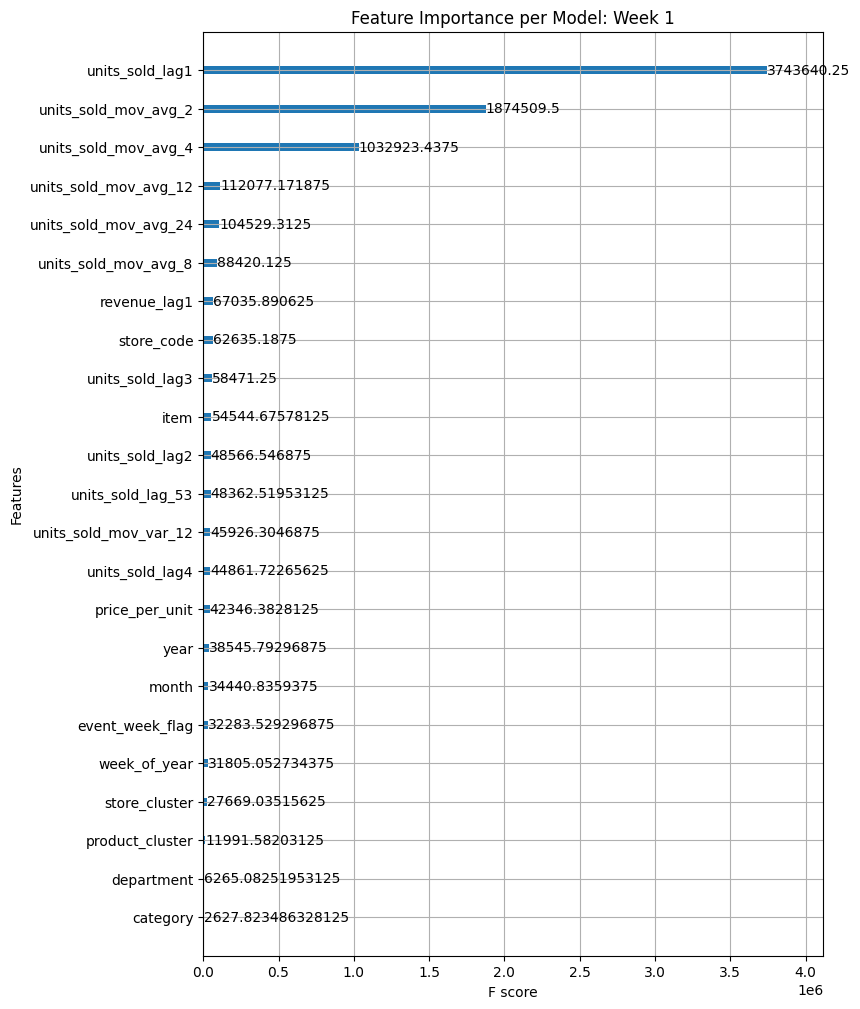

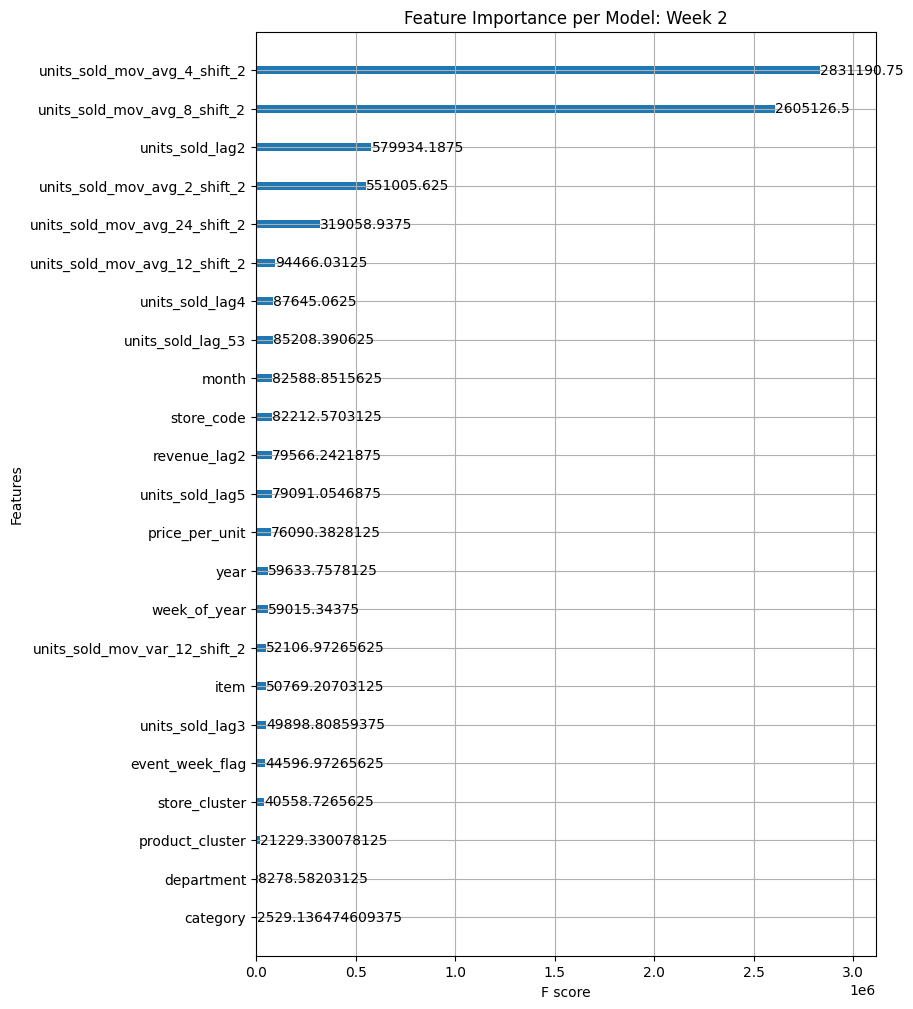

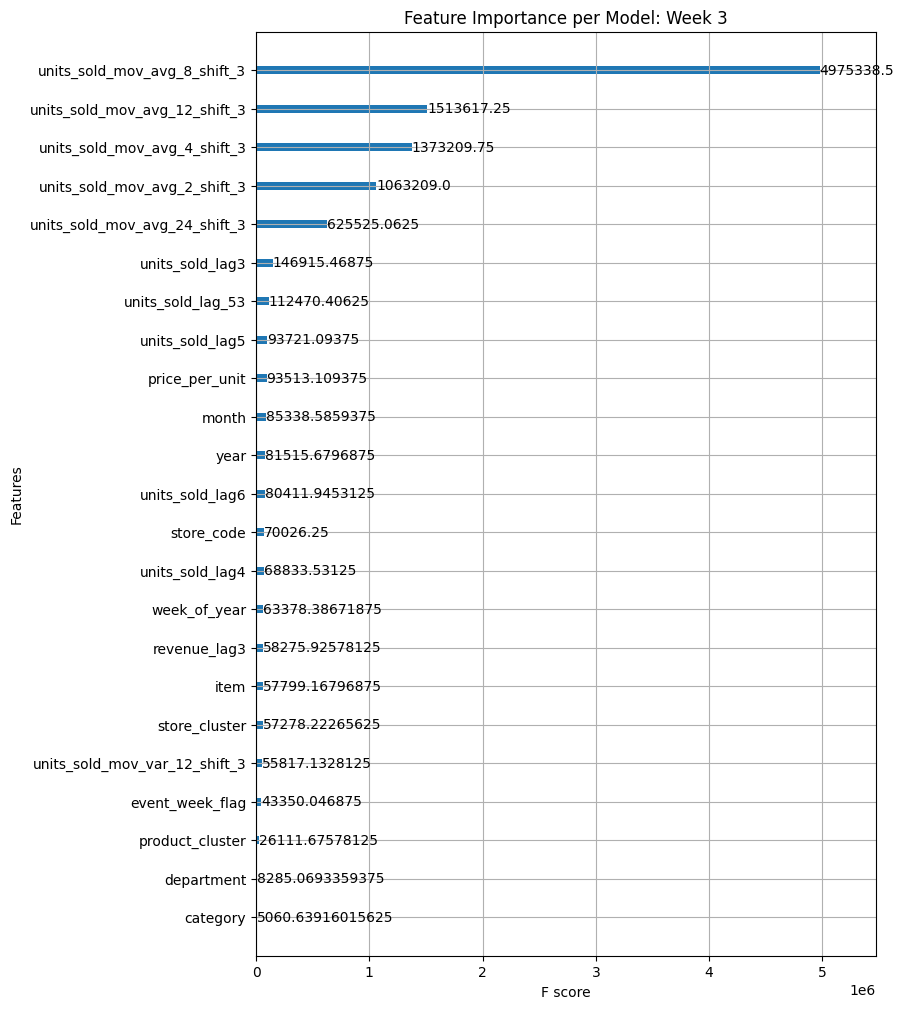

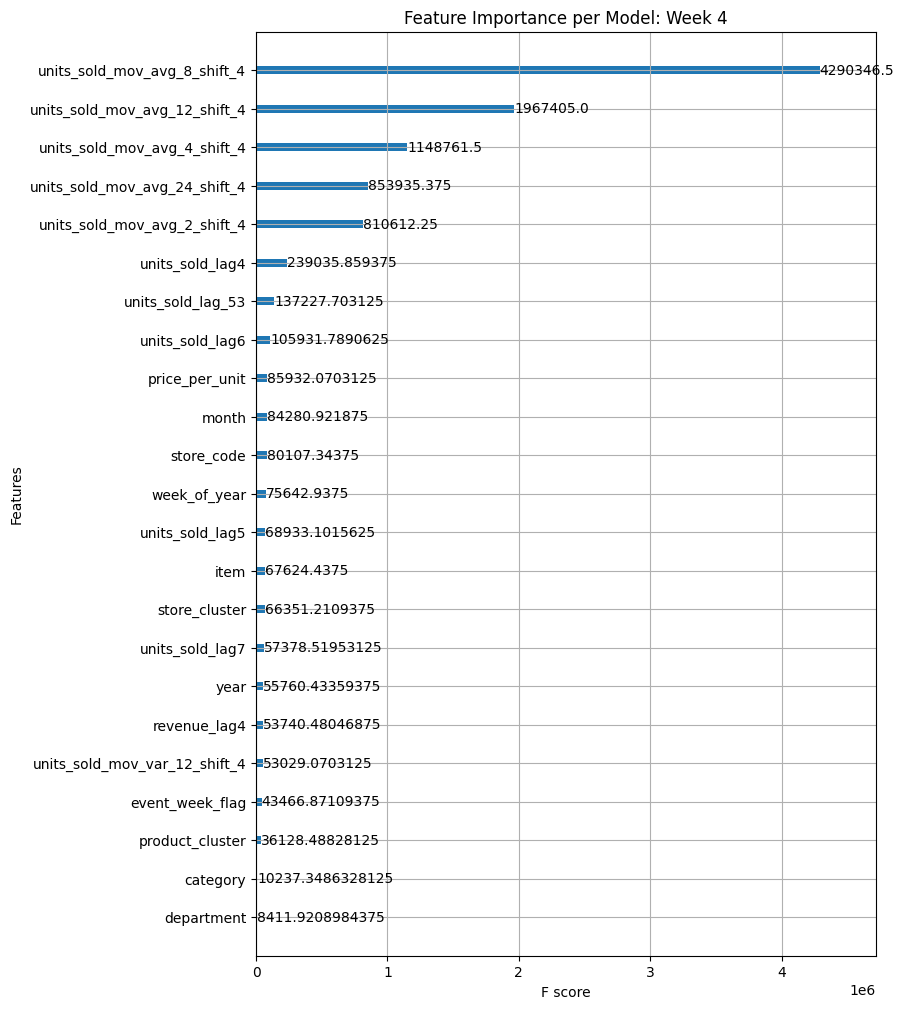

In [ ]:
for i in range(len(models)):
    fig, ax = plt.subplots(figsize=(8, 12))
    xgb.plot_importance(models[i], importance_type="gain", ax=ax)
    ax.set_title(f"Feature Importance per Model: Week {i+1}")
    plt.show()

# Make predictions

In [ ]:
df2_pred

,id,yearweek,item,category,department,store_code,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag2,units_sold_lag3,units_sold_lag4,units_sold_lag5,revenue_lag2,units_sold_mov_avg_12_shift_2,units_sold_mov_var_12_shift_2,units_sold_mov_avg_8_shift_2,units_sold_mov_avg_4_shift_2,units_sold_mov_avg_24_shift_2,units_sold_mov_avg_2_shift_2,units_sold_lag_53
3715388,ACCESORIES_1_001_BOS_1,201618,0.0,0.0,0.0,0.0,0.0,0,10.9858,0,4,1,18,5,2,2016,4.0,2.0,2.0,2.0,43.9432,2.166667,0.878788,2.500,2.50,1.791667,3.0,5.0
3715389,ACCESORIES_1_001_BOS_2,201618,0.0,0.0,0.0,1.0,0.0,0,10.9858,0,4,1,18,5,2,2016,1.0,1.0,3.0,3.0,10.9858,2.500000,4.090909,2.000,2.00,3.583333,1.0,5.0
3715390,ACCESORIES_1_001_BOS_3,201618,0.0,0.0,0.0,2.0,0.0,0,10.9858,0,4,1,18,5,2,2016,0.0,4.0,3.0,2.0,0.0000,3.083333,3.174242,2.875,2.25,3.750000,2.0,3.0
3715391,ACCESORIES_1_001_NYC_1,201618,0.0,0.0,0.0,3.0,1.0,0,11.1454,0,4,1,18,5,2,2016,8.0,5.0,12.0,2.0,89.1632,7.000000,10.909091,6.875,6.75,6.041667,6.5,5.0
3715392,ACCESORIES_1_001_NYC_2,201618,0.0,0.0,0.0,4.0,1.0,0,11.1454,0,4,3,18,5,2,2016,10.0,2.0,3.0,6.0,111.4540,5.250000,4.931818,5.625,5.25,4.958333,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745837,SUPERMARKET_3_827_NYC_3,201618,3046.0,2.0,6.0,5.0,1.0,0,1.2000,0,3,1,18,5,2,2016,38.0,39.0,43.0,24.0,45.6000,78.416667,3013.174242,59.625,36.00,52.541667,38.5,15.0
3745838,SUPERMARKET_3_827_NYC_4,201618,3046.0,2.0,6.0,6.0,1.0,0,1.2000,0,3,3,18,5,2,2016,22.0,0.0,7.0,29.0,26.4000,7.500000,86.090909,10.250,14.50,3.750000,11.0,0.0
3745839,SUPERMARKET_3_827_PHI_1,201618,3046.0,2.0,6.0,7.0,2.0,0,1.2000,0,3,2,18,5,2,2016,15.0,20.0,36.0,12.0,18.0000,26.000000,97.090909,25.750,20.75,24.291667,17.5,32.0
3745840,SUPERMARKET_3_827_PHI_2,201618,3046.0,2.0,6.0,8.0,2.0,0,1.2000,0,3,2,18,5,2,2016,12.0,17.0,22.0,28.0,14.4000,21.916667,50.446970,19.625,19.75,18.416667,14.5,16.0


Me aseguro que los dataset a predecir tengan las mismas columnas del dataset de entrenamiento

In [ ]:
X_PRED_LIST = []
for df_pred in DF_PRED_LIST:
    X_pred = df_pred.drop(columns=['units_sold', 'yearweek'])
    X_pred.set_index('id', inplace=True)
    X_PRED_LIST.append(X_pred)

In [ ]:
X_PRED_LIST[0]

,item,category,department,store_code,region,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold_lag1,units_sold_lag2,units_sold_lag3,units_sold_lag4,revenue_lag1,units_sold_mov_avg_12,units_sold_mov_var_12,units_sold_mov_avg_8,units_sold_mov_avg_4,units_sold_mov_avg_24,units_sold_mov_avg_2,units_sold_lag_53
id,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,0.0,0.0,0.0,0.0,0.0,10.9858,0,4,1,17,4,2,2016,4.0,2.0,2.0,2.0,43.9432,2.166667,0.878788,2.500,2.50,1.791667,3.0,4.0
ACCESORIES_1_001_BOS_2,0.0,0.0,0.0,1.0,0.0,10.9858,0,4,1,17,4,2,2016,1.0,1.0,3.0,3.0,10.9858,2.500000,4.090909,2.000,2.00,3.583333,1.0,4.0
ACCESORIES_1_001_BOS_3,0.0,0.0,0.0,2.0,0.0,10.9858,0,4,1,17,4,2,2016,0.0,4.0,3.0,2.0,0.0000,3.083333,3.174242,2.875,2.25,3.750000,2.0,7.0
ACCESORIES_1_001_NYC_1,0.0,0.0,0.0,3.0,1.0,11.1454,0,4,1,17,4,2,2016,8.0,5.0,12.0,2.0,89.1632,7.000000,10.909091,6.875,6.75,6.041667,6.5,6.0
ACCESORIES_1_001_NYC_2,0.0,0.0,0.0,4.0,1.0,11.1454,0,4,3,17,4,2,2016,10.0,2.0,3.0,6.0,111.4540,5.250000,4.931818,5.625,5.25,4.958333,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_827_NYC_3,3046.0,2.0,6.0,5.0,1.0,1.2000,0,3,1,17,4,2,2016,38.0,39.0,43.0,24.0,45.6000,78.416667,3013.174242,59.625,36.00,52.541667,38.5,16.0
SUPERMARKET_3_827_NYC_4,3046.0,2.0,6.0,6.0,1.0,1.2000,0,3,3,17,4,2,2016,22.0,0.0,7.0,29.0,26.4000,7.500000,86.090909,10.250,14.50,3.750000,11.0,0.0
SUPERMARKET_3_827_PHI_1,3046.0,2.0,6.0,7.0,2.0,1.2000,0,3,2,17,4,2,2016,15.0,20.0,36.0,12.0,18.0000,26.000000,97.090909,25.750,20.75,24.291667,17.5,24.0


In [ ]:
predictions = []
for model, X_pred in zip(models, X_PRED_LIST):
    y_pred = model.predict(X_pred)
    # Redondear las predicciones
    y_pred_rounded = np.round(y_pred).astype(int)
    predictions.append(y_pred_rounded)

In [ ]:
len(predictions)

4

In [ ]:
predictions[3]

array([ 2,  3,  3, ..., 21, 17,  5])

In [ ]:
df1_pred.columns.to_list()

['id',
 'yearweek',
 'item',
 'category',
 'department',
 'store_code',
 'region',
 'units_sold',
 'price_per_unit',
 'event_week_flag',
 'product_cluster',
 'store_cluster',
 'week_of_year',
 'month',
 'quarter',
 'year',
 'units_sold_lag1',
 'units_sold_lag2',
 'units_sold_lag3',
 'units_sold_lag4',
 'revenue_lag1',
 'units_sold_mov_avg_12',
 'units_sold_mov_var_12',
 'units_sold_mov_avg_8',
 'units_sold_mov_avg_4',
 'units_sold_mov_avg_24',
 'units_sold_mov_avg_2',
 'units_sold_lag_53']

In [ ]:
# selecciono solo las columnas que quiero en el dataset final
final_columns = [
 'id',
 'yearweek',
 'item',
 'category',
 'department',
 'store_code',
 'region',
 'price_per_unit',
 'units_sold',
 'event_week_flag',
 'product_cluster',
 'store_cluster',
 'week_of_year',
 'month',
 'quarter',
 'year'
]

Construyo el dataset final con los datos historicos por cada serie temporal y el valor de la prediccion de units_sold.

In [ ]:
DF_PREDICTED_LIST = []
for df_pred, i in zip(DF_PRED_LIST, range(len(predictions))):
    df_predicted = df_pred.drop(columns=['units_sold'])
    df_predicted['units_sold'] = predictions[i]
    df_predicted = df_predicted[final_columns].copy()
    DF_PREDICTED_LIST.append(df_predicted)

In [ ]:
DF_PREDICTED_LIST[0]

,id,yearweek,item,category,department,store_code,region,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
3684934,ACCESORIES_1_001_BOS_1,201617,0.0,0.0,0.0,0.0,0.0,10.9858,2,0,4,1,17,4,2,2016
3684935,ACCESORIES_1_001_BOS_2,201617,0.0,0.0,0.0,1.0,0.0,10.9858,2,0,4,1,17,4,2,2016
3684936,ACCESORIES_1_001_BOS_3,201617,0.0,0.0,0.0,2.0,0.0,10.9858,2,0,4,1,17,4,2,2016
3684937,ACCESORIES_1_001_NYC_1,201617,0.0,0.0,0.0,3.0,1.0,11.1454,7,0,4,1,17,4,2,2016
3684938,ACCESORIES_1_001_NYC_2,201617,0.0,0.0,0.0,4.0,1.0,11.1454,5,0,4,3,17,4,2,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715383,SUPERMARKET_3_827_NYC_3,201617,3046.0,2.0,6.0,5.0,1.0,1.2000,44,0,3,1,17,4,2,2016
3715384,SUPERMARKET_3_827_NYC_4,201617,3046.0,2.0,6.0,6.0,1.0,1.2000,19,0,3,3,17,4,2,2016
3715385,SUPERMARKET_3_827_PHI_1,201617,3046.0,2.0,6.0,7.0,2.0,1.2000,23,0,3,2,17,4,2,2016
3715386,SUPERMARKET_3_827_PHI_2,201617,3046.0,2.0,6.0,8.0,2.0,1.2000,19,0,3,2,17,4,2,2016


In [ ]:
df_final = df1[df1['yearweek']<=201616].copy()
df_final = df_final[final_columns].copy()

In [ ]:
df_final

,id,yearweek,item,category,department,store_code,region,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201401,0.0,0.0,0.0,0.0,0.0,10.9858,1,1,4,1,1,12,4,2013
1,ACCESORIES_1_001_BOS_2,201401,0.0,0.0,0.0,1.0,0.0,10.9858,1,1,4,1,1,12,4,2013
2,ACCESORIES_1_001_BOS_3,201401,0.0,0.0,0.0,2.0,0.0,11.1454,0,1,4,1,1,12,4,2013
3,ACCESORIES_1_001_NYC_1,201401,0.0,0.0,0.0,3.0,1.0,10.9858,2,1,4,1,1,12,4,2013
4,ACCESORIES_1_001_NYC_2,201401,0.0,0.0,0.0,4.0,1.0,10.9858,3,1,4,3,1,12,4,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3684929,SUPERMARKET_3_827_NYC_3,201616,3046.0,2.0,6.0,5.0,1.0,1.2000,38,0,3,1,16,4,2,2016
3684930,SUPERMARKET_3_827_NYC_4,201616,3046.0,2.0,6.0,6.0,1.0,1.2000,22,0,3,3,16,4,2,2016
3684931,SUPERMARKET_3_827_PHI_1,201616,3046.0,2.0,6.0,7.0,2.0,1.2000,15,0,3,2,16,4,2,2016
3684932,SUPERMARKET_3_827_PHI_2,201616,3046.0,2.0,6.0,8.0,2.0,1.2000,12,0,3,2,16,4,2,2016


In [ ]:
DF_PREDICTED_LIST[0]

,id,yearweek,item,category,department,store_code,region,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
3684934,ACCESORIES_1_001_BOS_1,201617,0.0,0.0,0.0,0.0,0.0,10.9858,2,0,4,1,17,4,2,2016
3684935,ACCESORIES_1_001_BOS_2,201617,0.0,0.0,0.0,1.0,0.0,10.9858,2,0,4,1,17,4,2,2016
3684936,ACCESORIES_1_001_BOS_3,201617,0.0,0.0,0.0,2.0,0.0,10.9858,2,0,4,1,17,4,2,2016
3684937,ACCESORIES_1_001_NYC_1,201617,0.0,0.0,0.0,3.0,1.0,11.1454,7,0,4,1,17,4,2,2016
3684938,ACCESORIES_1_001_NYC_2,201617,0.0,0.0,0.0,4.0,1.0,11.1454,5,0,4,3,17,4,2,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715383,SUPERMARKET_3_827_NYC_3,201617,3046.0,2.0,6.0,5.0,1.0,1.2000,44,0,3,1,17,4,2,2016
3715384,SUPERMARKET_3_827_NYC_4,201617,3046.0,2.0,6.0,6.0,1.0,1.2000,19,0,3,3,17,4,2,2016
3715385,SUPERMARKET_3_827_PHI_1,201617,3046.0,2.0,6.0,7.0,2.0,1.2000,23,0,3,2,17,4,2,2016
3715386,SUPERMARKET_3_827_PHI_2,201617,3046.0,2.0,6.0,8.0,2.0,1.2000,19,0,3,2,17,4,2,2016


In [ ]:
# concateno los dataset con las predicciones
df_final = pd.concat([df_final]+DF_PREDICTED_LIST)

In [ ]:
df_final

,id,yearweek,item,category,department,store_code,region,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201401,0.0,0.0,0.0,0.0,0.0,10.9858,1,1,4,1,1,12,4,2013
1,ACCESORIES_1_001_BOS_2,201401,0.0,0.0,0.0,1.0,0.0,10.9858,1,1,4,1,1,12,4,2013
2,ACCESORIES_1_001_BOS_3,201401,0.0,0.0,0.0,2.0,0.0,11.1454,0,1,4,1,1,12,4,2013
3,ACCESORIES_1_001_NYC_1,201401,0.0,0.0,0.0,3.0,1.0,10.9858,2,1,4,1,1,12,4,2013
4,ACCESORIES_1_001_NYC_2,201401,0.0,0.0,0.0,4.0,1.0,10.9858,3,1,4,3,1,12,4,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,201620,3046.0,2.0,6.0,5.0,1.0,1.2000,45,0,3,1,20,5,2,2016
3806746,SUPERMARKET_3_827_NYC_4,201620,3046.0,2.0,6.0,6.0,1.0,1.2000,14,0,3,3,20,5,2,2016
3806747,SUPERMARKET_3_827_PHI_1,201620,3046.0,2.0,6.0,7.0,2.0,1.2000,21,0,3,2,20,5,2,2016
3806748,SUPERMARKET_3_827_PHI_2,201620,3046.0,2.0,6.0,8.0,2.0,1.2000,17,0,3,2,20,5,2,2016


In [ ]:
df_final.drop(columns=['item','category','department','store_code','region'],inplace=True)

In [ ]:
df_final

,id,yearweek,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201401,10.9858,1,1,4,1,1,12,4,2013
1,ACCESORIES_1_001_BOS_2,201401,10.9858,1,1,4,1,1,12,4,2013
2,ACCESORIES_1_001_BOS_3,201401,11.1454,0,1,4,1,1,12,4,2013
3,ACCESORIES_1_001_NYC_1,201401,10.9858,2,1,4,1,1,12,4,2013
4,ACCESORIES_1_001_NYC_2,201401,10.9858,3,1,4,3,1,12,4,2013
...,...,...,...,...,...,...,...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,201620,1.2000,45,0,3,1,20,5,2,2016
3806746,SUPERMARKET_3_827_NYC_4,201620,1.2000,14,0,3,3,20,5,2,2016
3806747,SUPERMARKET_3_827_PHI_1,201620,1.2000,21,0,3,2,20,5,2,2016
3806748,SUPERMARKET_3_827_PHI_2,201620,1.2000,17,0,3,2,20,5,2,2016


In [ ]:
3654480 + (30454 * 4)

3776296

In [ ]:
temp_weekly_df_no_enc = weekly_df_no_enc[['id','item','category','department','store_code','store','region']].copy()

In [ ]:
temp_weekly_df_no_enc = temp_weekly_df_no_enc.groupby('id').agg(
    item = ('item','first'),
    category = ('category','first'),
    department = ('department','first'),
    store_code = ('store_code','first'),
    store = ('store','first'),
    region = ('region','first')
).reset_index()

In [ ]:
temp_weekly_df_no_enc

,id,item,category,department,store_code,store,region
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston
1,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Roxbury,Boston
2,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Back_Bay,Boston
3,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,Greenwich_Village,New York
4,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,Harlem,New York
...,...,...,...,...,...,...,...
30449,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York
30450,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_4,Brooklyn,New York
30451,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia
30452,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia


In [ ]:
df_final = df_final.merge(temp_weekly_df_no_enc,on='id',how='left')

In [ ]:
df_final

,id,yearweek,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,item,category,department,store_code,store,region
0,ACCESORIES_1_001_BOS_1,201401,10.9858,1,1,4,1,1,12,4,2013,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston
1,ACCESORIES_1_001_BOS_2,201401,10.9858,1,1,4,1,1,12,4,2013,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Roxbury,Boston
2,ACCESORIES_1_001_BOS_3,201401,11.1454,0,1,4,1,1,12,4,2013,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Back_Bay,Boston
3,ACCESORIES_1_001_NYC_1,201401,10.9858,2,1,4,1,1,12,4,2013,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,Greenwich_Village,New York
4,ACCESORIES_1_001_NYC_2,201401,10.9858,3,1,4,3,1,12,4,2013,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,Harlem,New York
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,201620,1.2000,45,0,3,1,20,5,2,2016,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York
3806746,SUPERMARKET_3_827_NYC_4,201620,1.2000,14,0,3,3,20,5,2,2016,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_4,Brooklyn,New York
3806747,SUPERMARKET_3_827_PHI_1,201620,1.2000,21,0,3,2,20,5,2,2016,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia
3806748,SUPERMARKET_3_827_PHI_2,201620,1.2000,17,0,3,2,20,5,2,2016,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia


Agrego la fecha para poder visualizar mejor los graficos finales

In [ ]:
weekly_df_no_enc

,id,yearweek,date,item,category,department,store_code,store,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201105,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,1,4,1,5,1,1,2011
1,ACCESORIES_1_001_BOS_1,201106,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,6,2,1,2011
2,ACCESORIES_1_001_BOS_1,201107,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,7,2,1,2011
3,ACCESORIES_1_001_BOS_1,201108,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,8,2,1,2011
4,ACCESORIES_1_001_BOS_1,201109,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,9,2,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435753,SUPERMARKET_3_827_PHI_3,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,16,4,2,2016
8435754,SUPERMARKET_3_827_PHI_3,201617,2016-05-01,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,17,4,2,2016
8435755,SUPERMARKET_3_827_PHI_3,201618,2016-05-08,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,18,5,2,2016
8435756,SUPERMARKET_3_827_PHI_3,201619,2016-05-15,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,19,5,2,2016


In [ ]:
yearweek_date_df = weekly_df_no_enc.groupby('yearweek')['date'].first()
yearweek_date_df = yearweek_date_df.reset_index().copy()

In [ ]:
yearweek_date_df

,yearweek,date
0,201105,2011-02-06
1,201106,2011-02-13
2,201107,2011-02-20
3,201108,2011-02-27
4,201109,2011-03-06
...,...,...
272,201616,2016-04-24
273,201617,2016-05-01
274,201618,2016-05-08
275,201619,2016-05-15


In [ ]:
df_final = df_final.merge(yearweek_date_df,on='yearweek',how='left')

In [ ]:
df_final.columns.to_list()

['id',
 'yearweek',
 'price_per_unit',
 'units_sold',
 'event_week_flag',
 'product_cluster',
 'store_cluster',
 'week_of_year',
 'month',
 'quarter',
 'year',
 'item',
 'category',
 'department',
 'store_code',
 'store',
 'region',
 'date']

In [ ]:
ordered_columns = [
 'id',
 'item',
 'category',
 'department',
 'store_code',
 'store',
 'region',
 'date',
 'yearweek',
 'price_per_unit',
 'units_sold',
 'event_week_flag',
 'product_cluster',
 'store_cluster',
 'week_of_year',
 'month',
 'quarter',
 'year'

]

In [ ]:
df_final = df_final[ordered_columns].copy()

In [ ]:
df_final

,id,item,category,department,store_code,store,region,date,yearweek,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,2014-01-05,201401,10.9858,1,1,4,1,1,12,4,2013
1,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Roxbury,Boston,2014-01-05,201401,10.9858,1,1,4,1,1,12,4,2013
2,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Back_Bay,Boston,2014-01-05,201401,11.1454,0,1,4,1,1,12,4,2013
3,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,Greenwich_Village,New York,2014-01-05,201401,10.9858,2,1,4,1,1,12,4,2013
4,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,Harlem,New York,2014-01-05,201401,10.9858,3,1,4,3,1,12,4,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,2016-05-22,201620,1.2000,45,0,3,1,20,5,2,2016
3806746,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_4,Brooklyn,New York,2016-05-22,201620,1.2000,14,0,3,3,20,5,2,2016
3806747,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia,2016-05-22,201620,1.2000,21,0,3,2,20,5,2,2016
3806748,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia,2016-05-22,201620,1.2000,17,0,3,2,20,5,2,2016


# Final results

In [ ]:
df_final

,id,item,category,department,store_code,store,region,date,yearweek,price_per_unit,units_sold,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,2014-01-05,201401,10.9858,1,1,4,1,1,12,4,2013
1,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Roxbury,Boston,2014-01-05,201401,10.9858,1,1,4,1,1,12,4,2013
2,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Back_Bay,Boston,2014-01-05,201401,11.1454,0,1,4,1,1,12,4,2013
3,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,Greenwich_Village,New York,2014-01-05,201401,10.9858,2,1,4,1,1,12,4,2013
4,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,Harlem,New York,2014-01-05,201401,10.9858,3,1,4,3,1,12,4,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,2016-05-22,201620,1.2000,45,0,3,1,20,5,2,2016
3806746,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_4,Brooklyn,New York,2016-05-22,201620,1.2000,14,0,3,3,20,5,2,2016
3806747,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia,2016-05-22,201620,1.2000,21,0,3,2,20,5,2,2016
3806748,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia,2016-05-22,201620,1.2000,17,0,3,2,20,5,2,2016


In [ ]:
df_final.columns

Index(['id', 'item', 'category', 'department', 'store_code', 'store', 'region',
       'date', 'yearweek', 'price_per_unit', 'units_sold', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year'],
      dtype='object')

## REVENUE

In [ ]:
df_final['revenue'] = df_final['units_sold'] * df_final['price_per_unit']

In [ ]:
df_final.columns

Index(['id', 'item', 'category', 'department', 'store_code', 'store', 'region',
       'date', 'yearweek', 'price_per_unit', 'units_sold', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year', 'revenue'],
      dtype='object')

In [ ]:
df_final_org = df_final[['id', 'item', 'category', 'department', 'store_code', 'store', 'region', 'date', 'yearweek', 'week_of_year', 'month', 'quarter', 'year', 'units_sold', 'revenue', 'price_per_unit', 'event_week_flag', 'product_cluster', 'store_cluster']].copy()
df_final_org

,id,item,category,department,store_code,store,region,date,yearweek,week_of_year,month,quarter,year,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster
0,ACCESORIES_1_001_BOS_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,2014-01-05,201401,1,12,4,2013,1,10.9858,10.9858,1,4,1
1,ACCESORIES_1_001_BOS_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Roxbury,Boston,2014-01-05,201401,1,12,4,2013,1,10.9858,10.9858,1,4,1
2,ACCESORIES_1_001_BOS_3,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Back_Bay,Boston,2014-01-05,201401,1,12,4,2013,0,0.0000,11.1454,1,4,1
3,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,Greenwich_Village,New York,2014-01-05,201401,1,12,4,2013,2,21.9716,10.9858,1,4,1
4,ACCESORIES_1_001_NYC_2,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,Harlem,New York,2014-01-05,201401,1,12,4,2013,3,32.9574,10.9858,1,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,2016-05-22,201620,20,5,2,2016,45,54.0000,1.2000,0,3,1
3806746,SUPERMARKET_3_827_NYC_4,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_4,Brooklyn,New York,2016-05-22,201620,20,5,2,2016,14,16.8000,1.2000,0,3,3
3806747,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia,2016-05-22,201620,20,5,2,2016,21,25.2000,1.2000,0,3,2
3806748,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia,2016-05-22,201620,20,5,2,2016,17,20.4000,1.2000,0,3,2


In [ ]:
df_final_org[['id', 'units_sold', 'revenue', 'yearweek']]

,id,units_sold,revenue,yearweek
0,ACCESORIES_1_001_BOS_1,1,10.9858,201401
1,ACCESORIES_1_001_BOS_2,1,10.9858,201401
2,ACCESORIES_1_001_BOS_3,0,0.0000,201401
3,ACCESORIES_1_001_NYC_1,2,21.9716,201401
4,ACCESORIES_1_001_NYC_2,3,32.9574,201401
...,...,...,...,...
3806745,SUPERMARKET_3_827_NYC_3,45,54.0000,201620
3806746,SUPERMARKET_3_827_NYC_4,14,16.8000,201620
3806747,SUPERMARKET_3_827_PHI_1,21,25.2000,201620
3806748,SUPERMARKET_3_827_PHI_2,17,20.4000,201620


In [ ]:
report_df(df_final_org)

Shape: 3806750 rows, 19 columns

--------------------------------------------------------------------------------
Columns of type Object (7):
['id', 'item', 'category', 'department', 'store_code', 'store', 'region']

--------------------------------------------------------------------------------
Columns of type Int (5):
['yearweek', 'units_sold', 'event_week_flag', 'product_cluster', 'store_cluster']

--------------------------------------------------------------------------------
Columns of type Float (2):
['revenue', 'price_per_unit']

--------------------------------------------------------------------------------
Columns of type Boolean (0):
[]

--------------------------------------------------------------------------------
Columns of type Datetime (1):
['date']

--------------------------------------------------------------------------------
Total missing values: 0
Total duplicate rows: 0
Min yearweek is 201401
Max yearweek is 201620
Number of ids: 30454
Number of categories: 3


## Last_year_sales

In [ ]:
df_final_org['id'].sample(5).tolist()

['HOME_&_GARDEN_2_510_NYC_1',
 'SUPERMARKET_2_100_BOS_1',
 'HOME_&_GARDEN_1_237_BOS_1',
 'SUPERMARKET_2_350_BOS_1',
 'HOME_&_GARDEN_2_125_NYC_4']

In [ ]:
# Filter the DataFrame for the specified ID and yearweeks
filtered_df = df_final_org[
    (df_final_org['id'] == 'HOME_&_GARDEN_2_312_NYC_4') &
    ((df_final_org['yearweek'] == 201620) | (df_final_org['yearweek'] == 201520))
]

# Select the relevant columns
result_df = filtered_df[['id', 'yearweek', 'units_sold']]

# Display the result
result_df

,id,yearweek,units_sold
2176278,HOME_&_GARDEN_2_312_NYC_4,201520,7
3790340,HOME_&_GARDEN_2_312_NYC_4,201620,7


In [ ]:
# Filter the DataFrame for the specified ID
filtered_df = df_final_org[df_final_org['id'] == 'HOME_&_GARDEN_2_312_NYC_4']

# Create a new DataFrame with the lags
result_df = filtered_df[['id', 'yearweek', 'units_sold']].copy()

# Calculate the lags
for lag in [53, 105]:
    result_df[f"units_sold_lag_{lag}"] = result_df['units_sold'].shift(lag)

# Display the result
result_df[result_df['yearweek'] == 201620]

,id,yearweek,units_sold,units_sold_lag_53,units_sold_lag_105
3790340,HOME_&_GARDEN_2_312_NYC_4,201620,7,7.0,0.0


In [ ]:
df_final_org["units_sold_last_year"] = df_final_org.groupby('id')['units_sold'].shift(53)

In [ ]:
df_final_org[(df_final_org['id'] == 'HOME_&_GARDEN_2_312_NYC_4') & (df_final_org['yearweek'] == 201620)]

,id,item,category,department,store_code,store,region,date,yearweek,week_of_year,month,quarter,year,units_sold,revenue,price_per_unit,event_week_flag,product_cluster,store_cluster,units_sold_last_year
3790340,HOME_&_GARDEN_2_312_NYC_4,HOME_&_GARDEN_2_312,HOME_&_GARDEN,HOME_&_GARDEN_2,NYC_4,Brooklyn,New York,2016-05-22,201620,20,5,2,2016,7,34.7375,4.9625,0,3,3,7.0


In [ ]:
# df_final_org['units_sold_last_year'] = df_final_org['units_sold_last_year'].fillna(0).astype(int)

In [ ]:
df_final_org.columns

Index(['id', 'item', 'category', 'department', 'store_code', 'store', 'region',
       'date', 'yearweek', 'week_of_year', 'month', 'quarter', 'year',
       'units_sold', 'revenue', 'price_per_unit', 'event_week_flag',
       'product_cluster', 'store_cluster', 'units_sold_last_year'],
      dtype='object')

In [ ]:
# Current column order
current_columns = df_final_org.columns.tolist()

# Define the new column order
new_order = [
    'id', 'item', 'category', 'department', 'store_code', 'store', 'region',
    'date', 'yearweek', 'week_of_year', 'month', 'quarter', 'year',
    'units_sold', 'revenue', 'price_per_unit', 'units_sold_last_year',
    'event_week_flag', 'product_cluster', 'store_cluster'
]

# Reorder the DataFrame columns
df_final_org = df_final_org[new_order]

# Verify the new column order
df_final_org.columns

Index(['id', 'item', 'category', 'department', 'store_code', 'store', 'region',
       'date', 'yearweek', 'week_of_year', 'month', 'quarter', 'year',
       'units_sold', 'revenue', 'price_per_unit', 'units_sold_last_year',
       'event_week_flag', 'product_cluster', 'store_cluster'],
      dtype='object')

In [ ]:
df_final_org.tail(3)

,id,item,category,department,store_code,store,region,date,yearweek,week_of_year,month,quarter,year,units_sold,revenue,price_per_unit,units_sold_last_year,event_week_flag,product_cluster,store_cluster
3806747,SUPERMARKET_3_827_PHI_1,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia,2016-05-22,201620,20,5,2,2016,21,25.2,1.2,29.0,0,3,2
3806748,SUPERMARKET_3_827_PHI_2,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia,2016-05-22,201620,20,5,2,2016,17,20.4,1.2,1.0,0,3,2
3806749,SUPERMARKET_3_827_PHI_3,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,2016-05-22,201620,20,5,2,2016,5,6.0,1.2,12.0,0,3,1


In [ ]:
df_final_org['date'] = pd.to_datetime(df_final_org['date'])

## CSV

In [ ]:
df_final_org['units_sold_last_year'] = df_final_org['units_sold_last_year'].fillna(0).astype(int)

In [ ]:
df_final_org.to_csv('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df_final_con_revenue_y_predicciones.csv',index=False)

In [ ]:
df_final_org = pd.read_csv('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df_final_con_revenue_y_predicciones.csv')

## PLOTS

In [ ]:
def plot_single_ts(df, ts_id, year):
    # Filtrar el dataframe por id y año
    df = df[(df['id'] == ts_id) & (df['year'] == year)]

    # Determinar las últimas 4 semanas
    last_4_weeks = df['date'].max() - pd.DateOffset(weeks=4)
    df_history = df[df['date'] <= last_4_weeks]  # Parte histórica
    df_forecast = df[df['date'] >= last_4_weeks]  # Últimas 4 semanas (predicción)

    # Crear el gráfico
    plt.figure(figsize=(30, 7))

    # Parte histórica (línea en azul)
    plt.plot(df_history['date'], df_history['units_sold'], label=f'Historical', lw=4, color='blue')

    # Parte de predicción (línea en rojo)
    plt.plot(df_forecast['date'], df_forecast['units_sold'], label=f'Forecast (Next 4 weeks)', lw=4, color='red')

    # Plot units_sold_last_year for historical and forecast periods (green line)
    plt.plot(df['date'], df['units_sold_last_year'], label=f'Last Year Sales', lw=2, color='green', linestyle='--')

    # Configurar el título y la leyenda
    plt.title(f'{ts_id} Units Sold')
    plt.legend(loc="upper left")

    # Configurar el formato de las fechas en el eje X
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Configurar un localizador semanal
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

    # Rotar las fechas para que sean legibles
    plt.gcf().autofmt_xdate()

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [ ]:
ID_RANDOM_LIST = df_final_org['id'].sample(5)
ID_RANDOM_LIST

,id
3741420,SUPERMARKET_3_382_PHI_1
3768596,SUPERMARKET_3_054_PHI_3
1058757,SUPERMARKET_3_111_NYC_4
545616,SUPERMARKET_3_569_NYC_1
1853739,SUPERMARKET_3_429_NYC_2


In [ ]:
ID_RANDOM_LIST = df_final_org['id'].sample(5)
ID_RANDOM_LIST

,id
2998392,HOME_&_GARDEN_2_298_BOS_3
2880212,SUPERMARKET_1_147_PHI_2
1896792,HOME_&_GARDEN_1_308_NYC_2
2618169,SUPERMARKET_3_739_NYC_2
3711865,SUPERMARKET_3_472_NYC_4


In [ ]:
for id in ID_RANDOM_LIST:
  plot_single_ts(df_final_org,ts_id=id, year=2016)

TypeError: unsupported operand type(s) for -: 'str' and 'DateOffset'

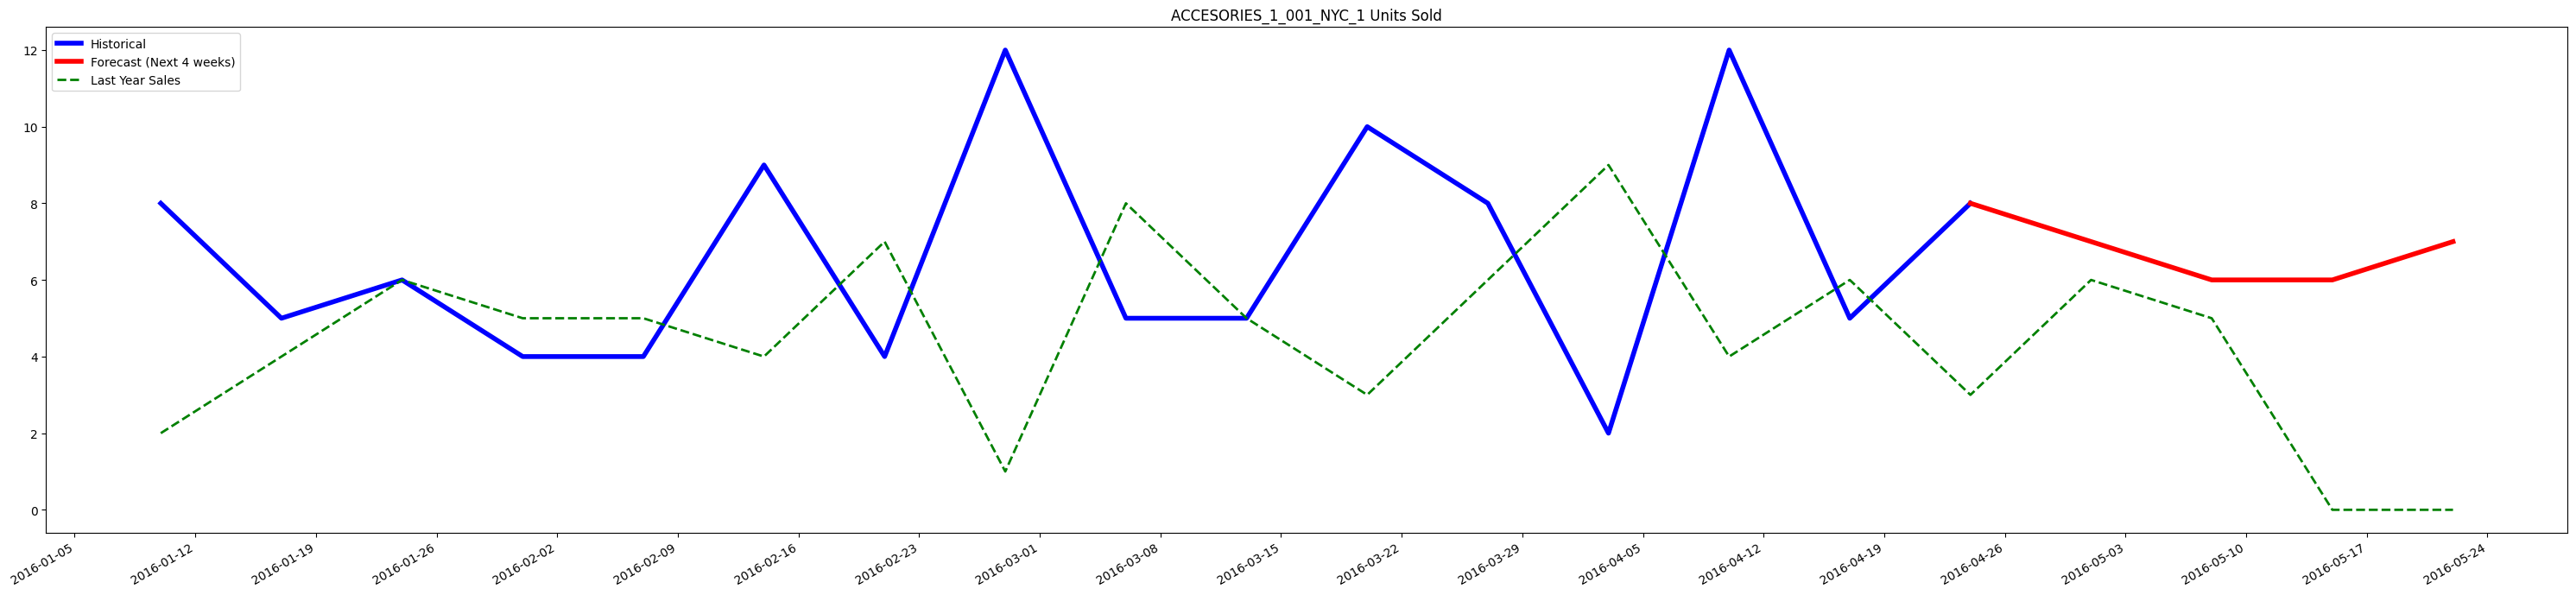

In [ ]:
plot_single_ts(df_final_org,'ACCESORIES_1_001_NYC_1',year=2016)

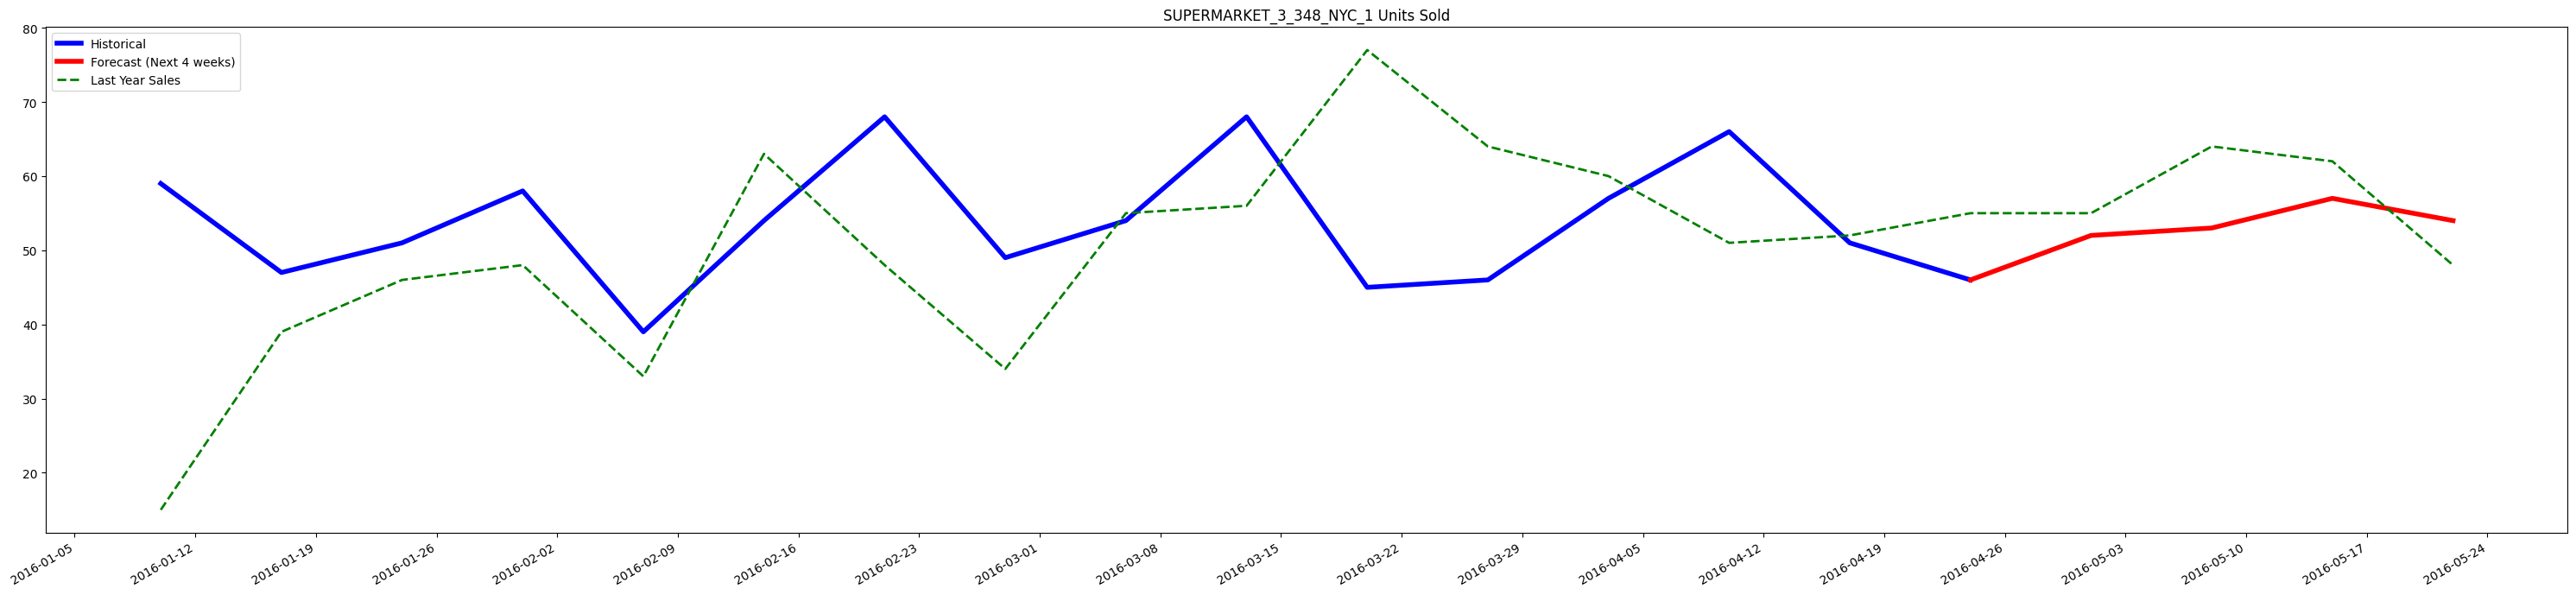

In [ ]:
plot_single_ts(df_final_org,'SUPERMARKET_3_348_NYC_1',year=2016)

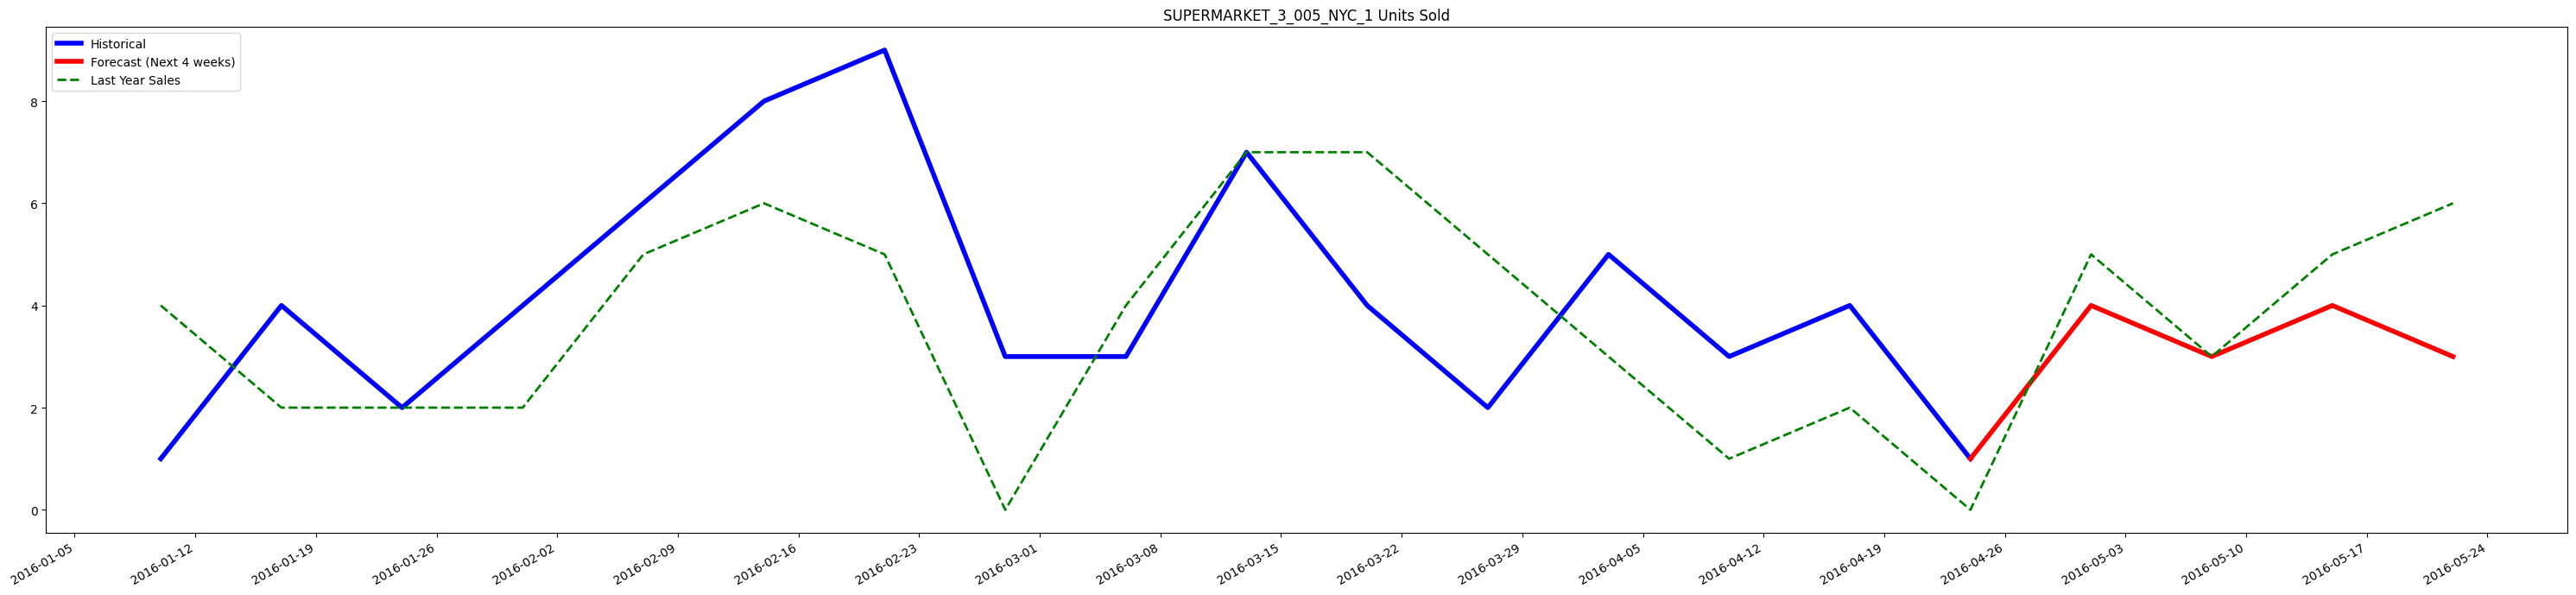

In [ ]:
plot_single_ts(df_NYC_1,'SUPERMARKET_3_005_NYC_1',year=2016)

# PLOTS

In [ ]:
def plot_all_categories_together(df, ts_categories, year):
    # Asegurarse de que la columna 'date' esté en formato datetime
    df['date'] = pd.to_datetime(df['date'])

    plt.figure(figsize=(18, 12))

    # Iterar sobre cada categoría en la lista
    for ts_category in ts_categories:
        # Filtrar el dataframe por categoría y año
        df_filtered = df[(df['category'] == ts_category) & (df['year'] == year)]

        if df_filtered.empty:
            print(f"No data available for category: {ts_category}")
            continue

        # Determinar las últimas 4 semanas
        last_4_weeks = df_filtered['date'].max() - pd.DateOffset(weeks=4)
        df_history = df_filtered[df_filtered['date'] <= last_4_weeks]  # Parte histórica
        df_forecast = df_filtered[df_filtered['date'] >= last_4_weeks]  # Últimas 4 semanas (predicción)

        # Sumar las unidades vendidas
        history_sum = df_history.groupby('date')['units_sold'].sum()
        forecast_sum = df_forecast.groupby('date')['units_sold'].sum()
        last_year_sum = df_filtered.groupby('date')['units_sold_last_year'].sum()

        # Parte histórica (línea azul) para cada categoría
        plt.plot(history_sum.index, history_sum, label=f'Historico {ts_category}', lw=2, color='blue')

        # Parte de predicción (línea verde)
        plt.plot(forecast_sum.index, forecast_sum, lw=2, linestyle='--', label=f'Predicción {ts_category}', color='green')

        # Último año (línea naranja)
        plt.plot(last_year_sum.index, last_year_sum, lw=2, linestyle=':', label=f'Ventas del Año Pasado {ts_category}', color='orange')

    # Configurar el formato de las fechas en el eje X para mostrar solo el mes
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

    # Configurar un localizador de mes para que el mes solo salga una vez
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    # Configurar el título y la leyenda
    plt.title(f'Unidades Vendidas - Comparación por Categoría', fontsize=14)
    # plt.legend(loc="upper left", fontsize=10, bbox_to_anchor=(1, 1))

    # Rotar las fechas para que sean legibles
    plt.gcf().autofmt_xdate()

    # Ajustar el diseño para evitar superposiciones
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [ ]:
cat_list = df_final_org['category'].unique().tolist()

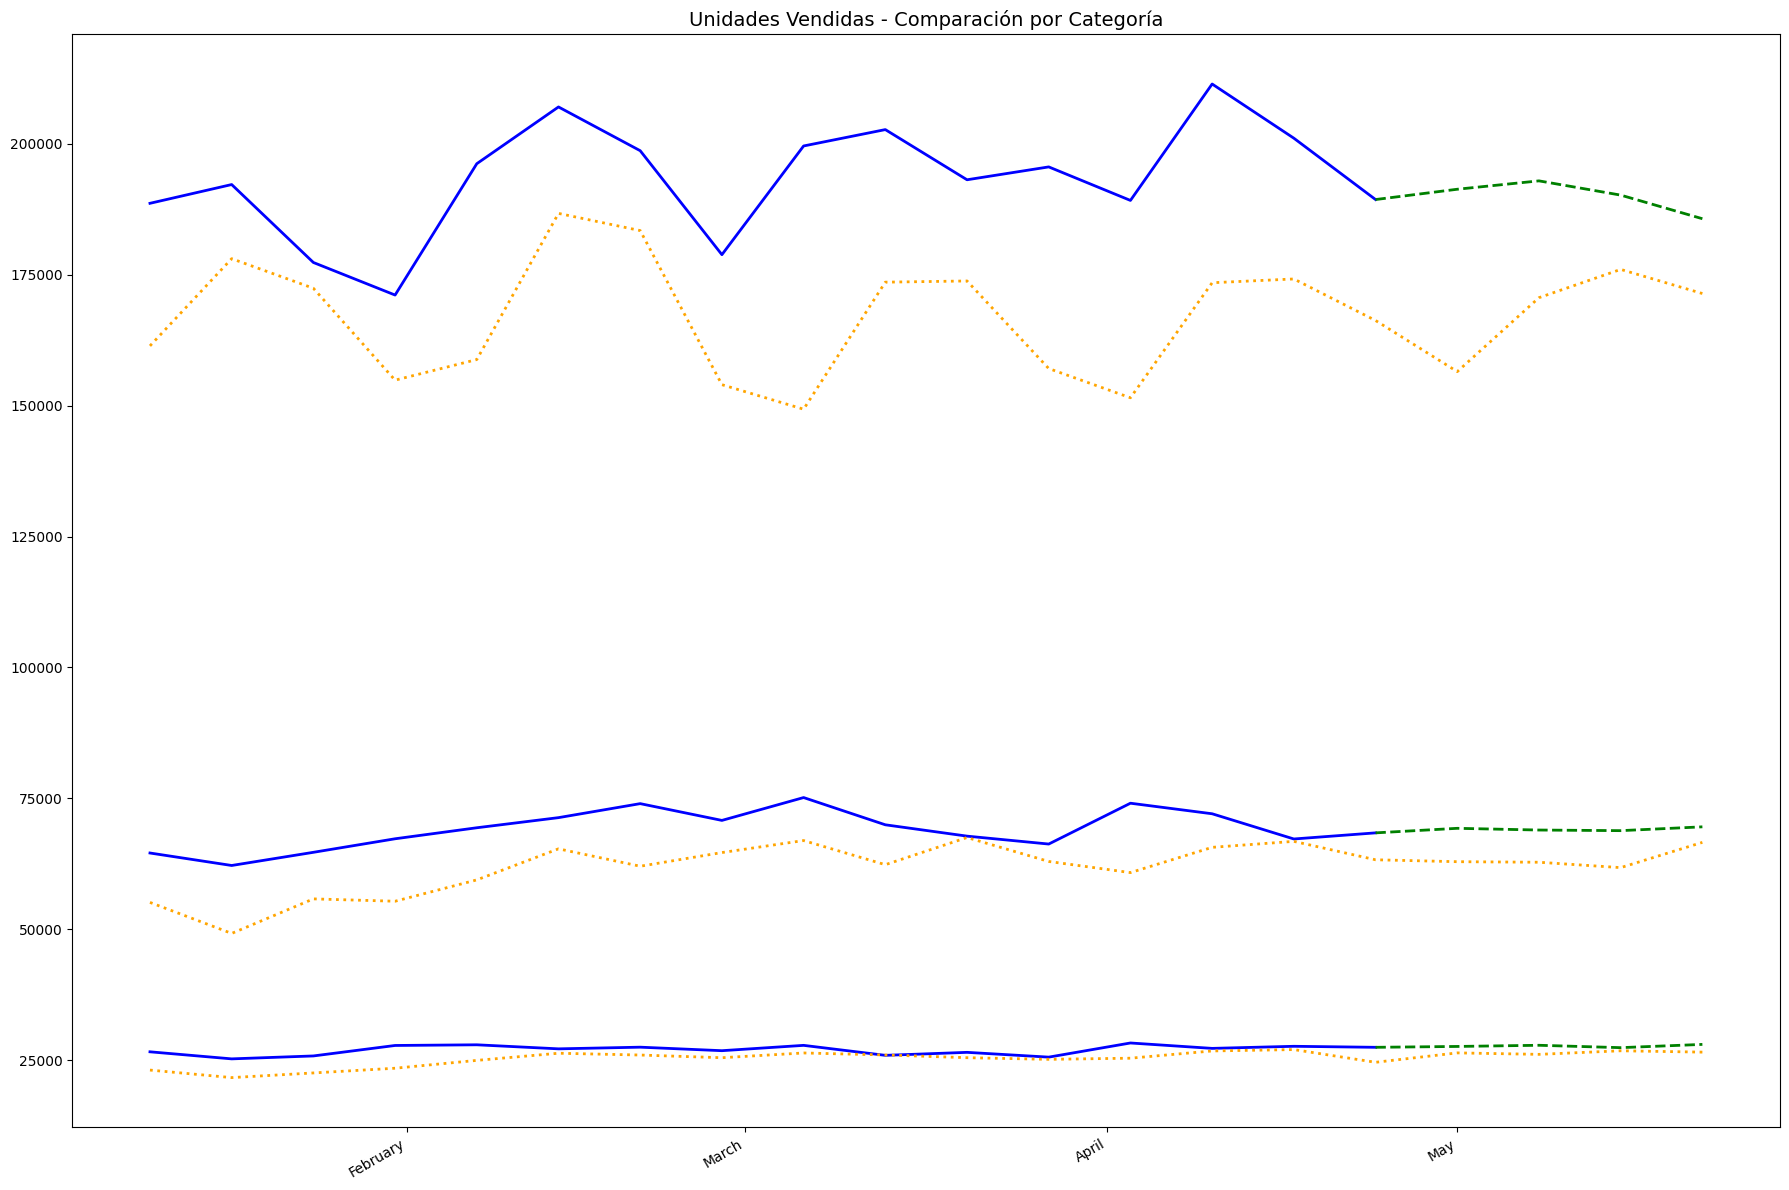

In [ ]:
plot_all_categories_together(df_final_org, cat_list, year=2016)

In [ ]:
store_cluster_mapping = df_final_org.groupby('store_cluster')['store'].unique()

store_cluster_mapping

,store
store_cluster,
1,"[South_End, Roxbury, Back_Bay, Greenwich_Villa..."
2,"[Midtown_Village, Yorktown]"
3,"[Harlem, Brooklyn]"


In [ ]:
store_list = df_final_org['store'].unique().tolist()

In [ ]:
store_list

['South_End',
 'Roxbury',
 'Back_Bay',
 'Greenwich_Village',
 'Harlem',
 'Tribeca',
 'Brooklyn',
 'Midtown_Village',
 'Yorktown',
 'Queen_Village']

In [ ]:
def plot_stores_2016_onward(df, store_list):
    # Asegurarse de que la columna 'date' esté en formato datetime
    df['date'] = pd.to_datetime(df['date'])

    # Filtrar el dataframe para tomar solo datos del 2016 en adelante
    df_filtered_2016 = df[df['date'] >= '2016-01-01']

    # Iterar sobre cada tienda en la lista y crear un gráfico por tienda
    for store in store_list:
        # Filtrar el dataframe por tienda
        df_filtered_store = df_filtered_2016[df_filtered_2016['store'] == store]

        if df_filtered_store.empty:
            print(f"No data available for store: {store}")
            continue

        # Determinar las últimas 4 semanas
        last_4_weeks = df_filtered_store['date'].max() - pd.DateOffset(weeks=4)
        df_history = df_filtered_store[df_filtered_store['date'] <= last_4_weeks]  # Parte histórica
        df_forecast = df_filtered_store[df_filtered_store['date'] >= last_4_weeks]  # Últimas 4 semanas (predicción)

        # Sumar las unidades vendidas
        history_sum = df_history.groupby('date')['units_sold'].sum()
        forecast_sum = df_forecast.groupby('date')['units_sold'].sum()
        last_year_sum = df_filtered_store.groupby('date')['units_sold_last_year'].sum()

        # Crear un gráfico para la tienda actual
        plt.figure(figsize=(12, 6))

        # Parte histórica (línea azul)
        plt.plot(history_sum.index, history_sum, label='Historico', lw=2, color='blue')

        # Parte de predicción (línea verde)
        plt.plot(forecast_sum.index, forecast_sum, lw=2, linestyle='--', label='Predicción', color='green')

        # Último año (línea naranja)
        plt.plot(last_year_sum.index, last_year_sum, lw=2, linestyle=':', label='Ventas del Año Pasado', color='orange')

        # Configurar el formato de las fechas en el eje X para mostrar solo el mes
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B'))

        # Configurar un localizador de mes para que el mes solo salga una vez
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

        # Configurar el título y la leyenda
        plt.title(f'Unidades Vendidas - {store} (2016 en adelante)', fontsize=14)
        plt.legend(loc="upper left", fontsize=10)

        # Rotar las fechas para que sean legibles
        plt.gcf().autofmt_xdate()

        # Ajustar el diseño para evitar superposiciones
        plt.tight_layout()

        # Mostrar el gráfico
        plt.show()

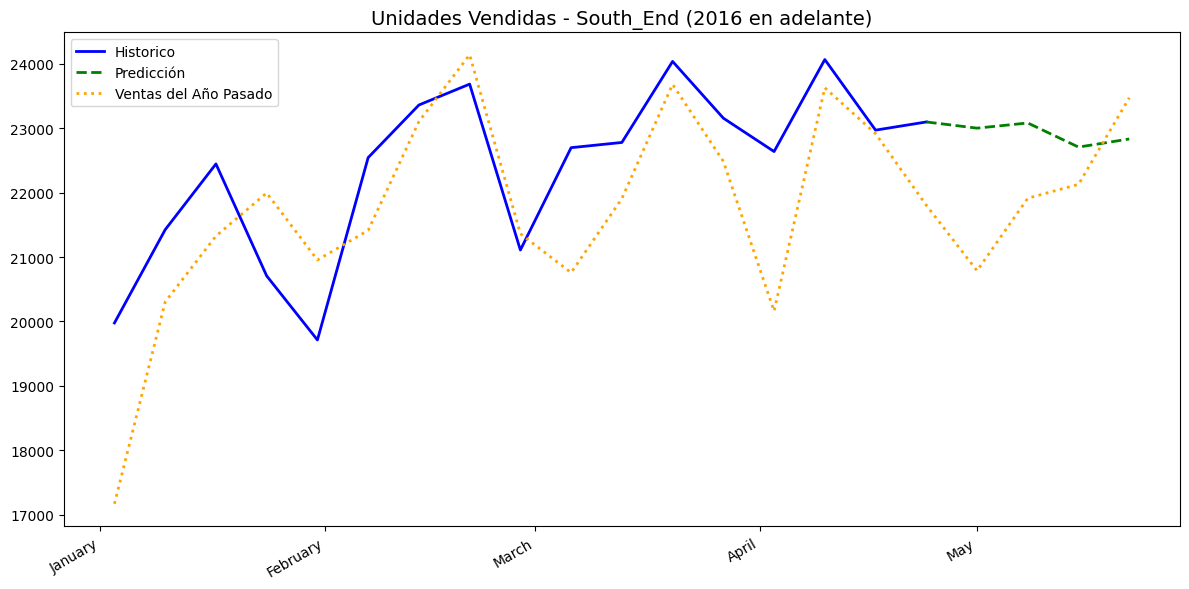

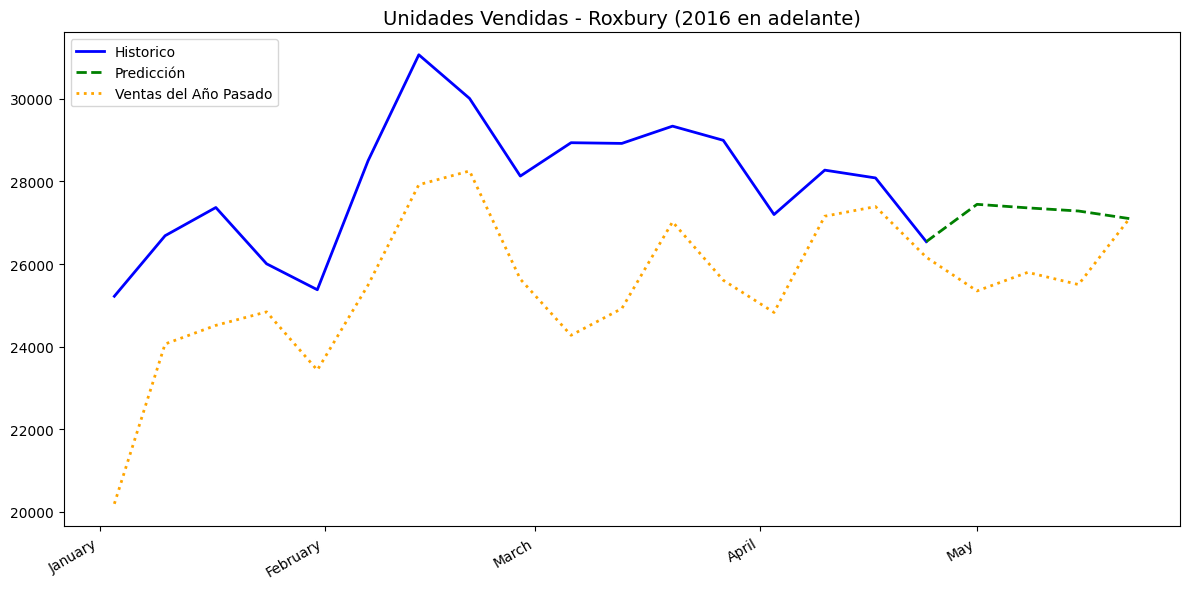

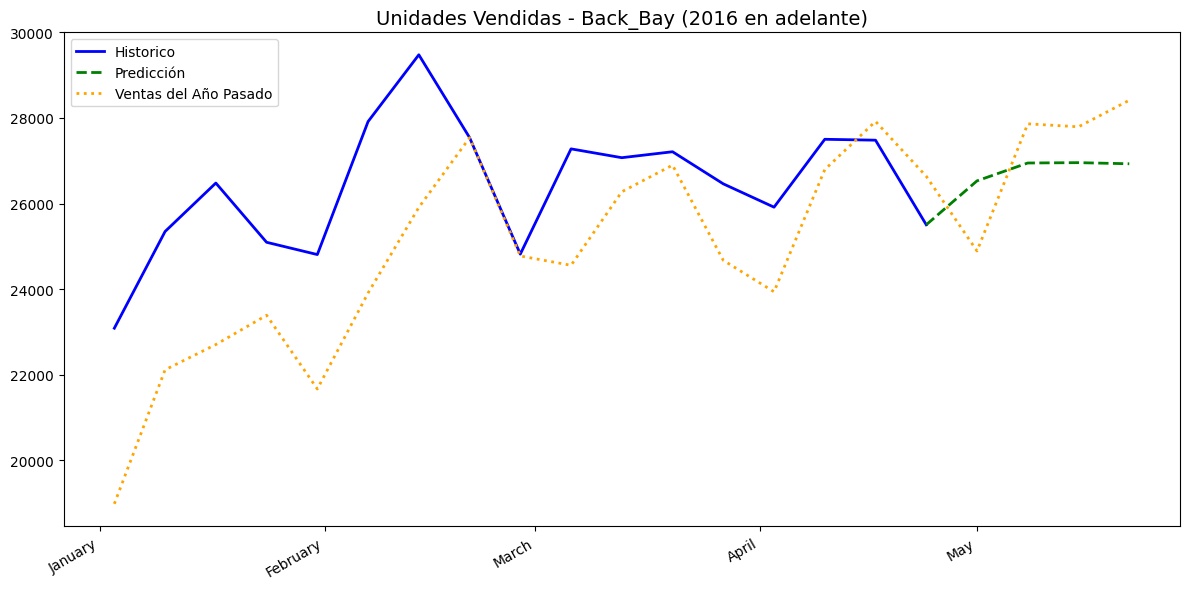

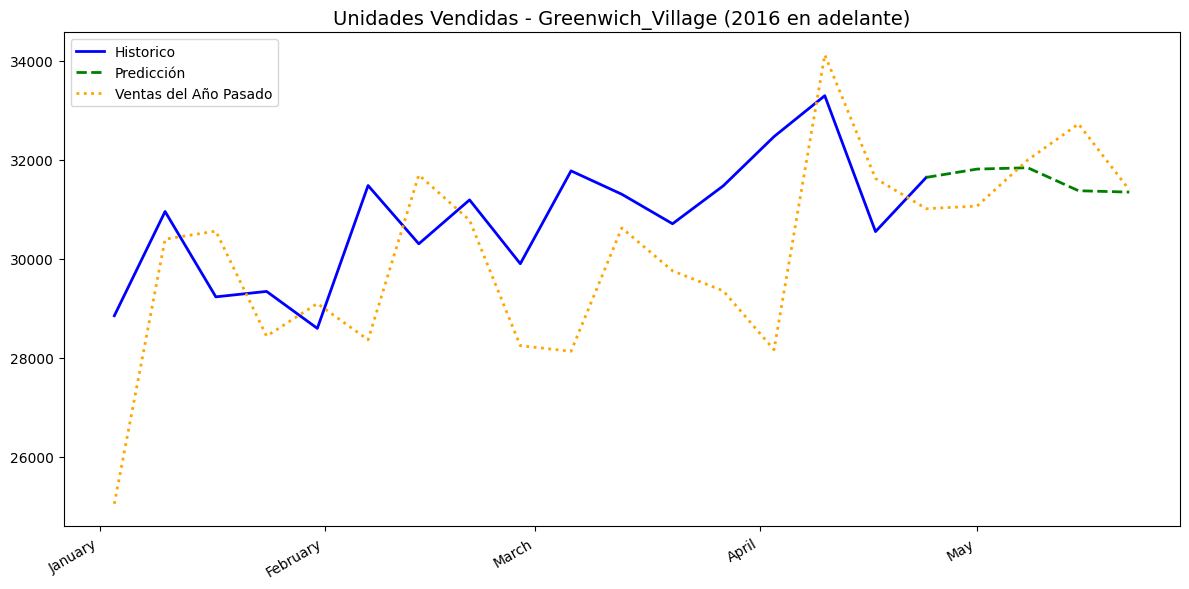

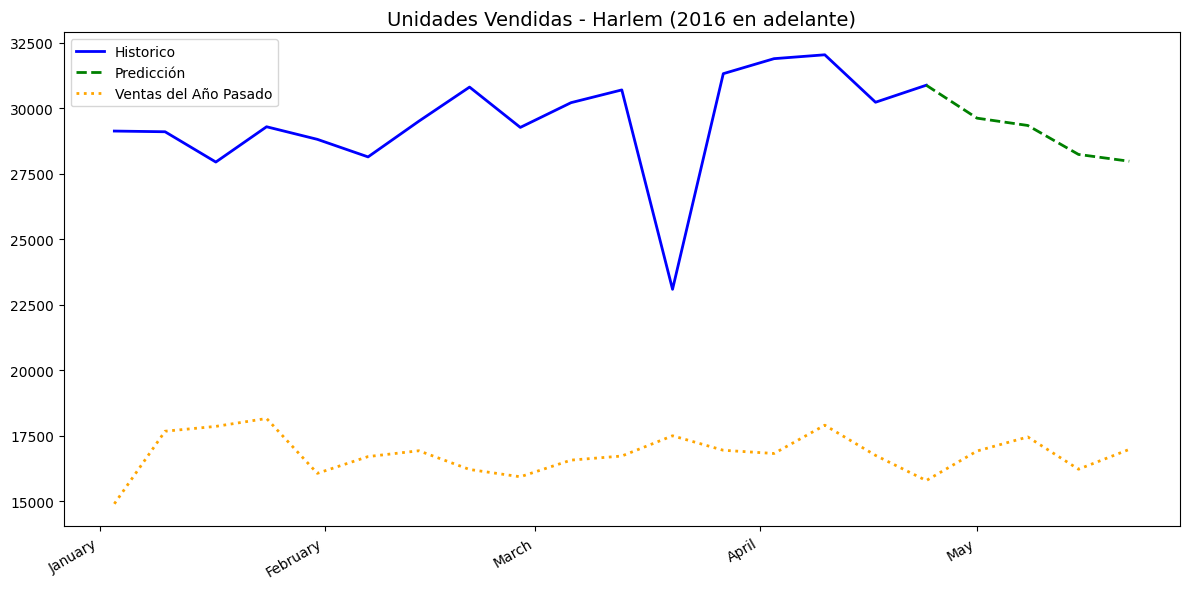

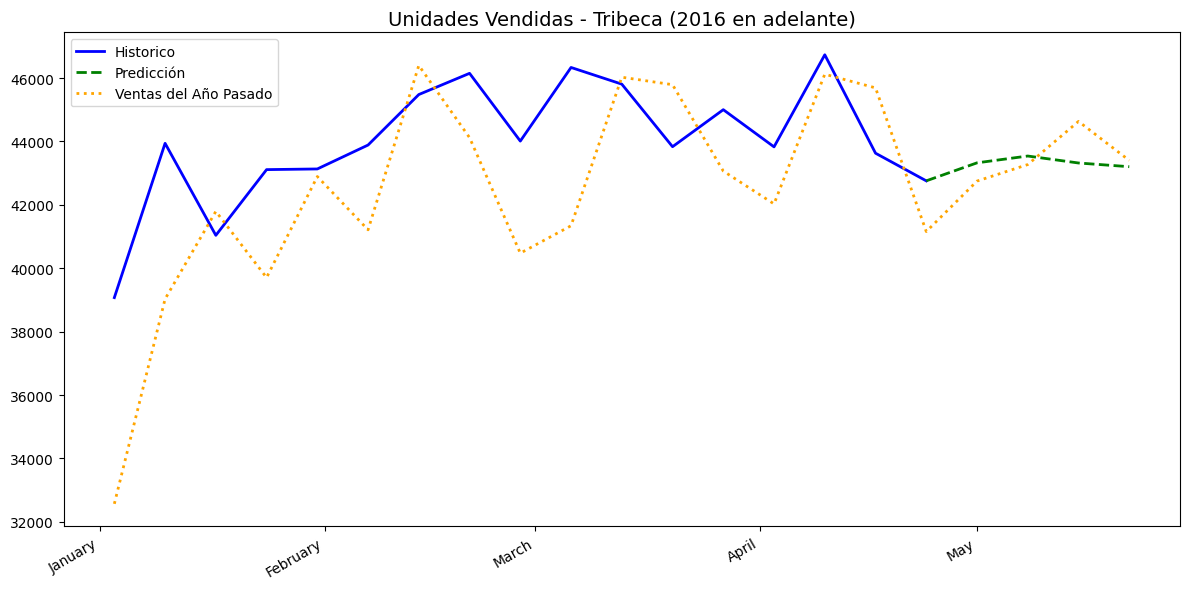

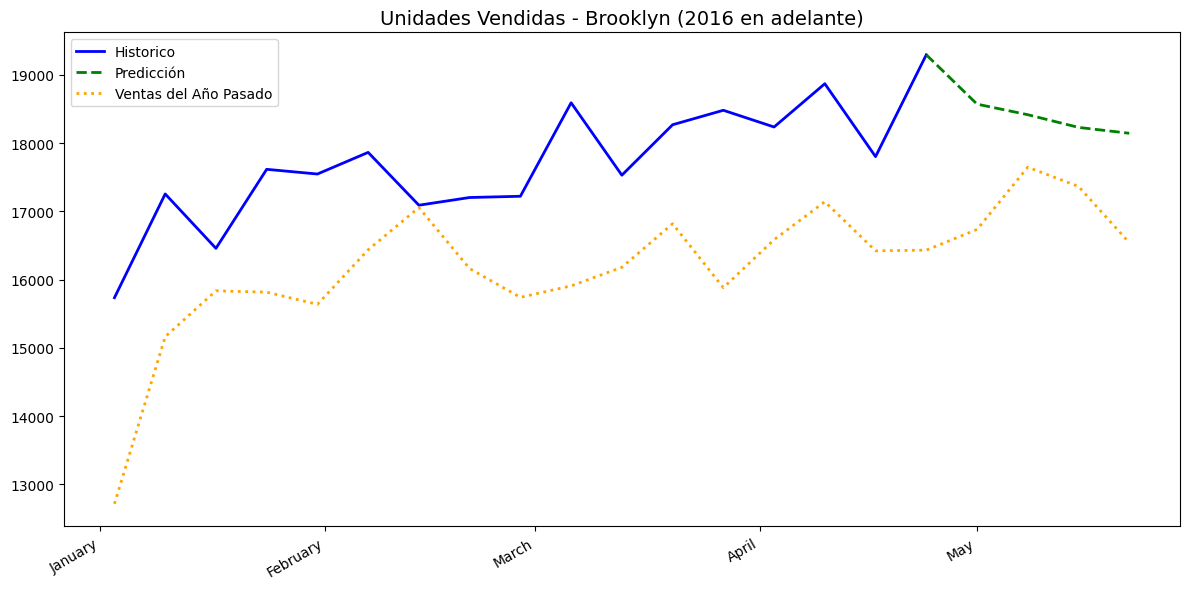

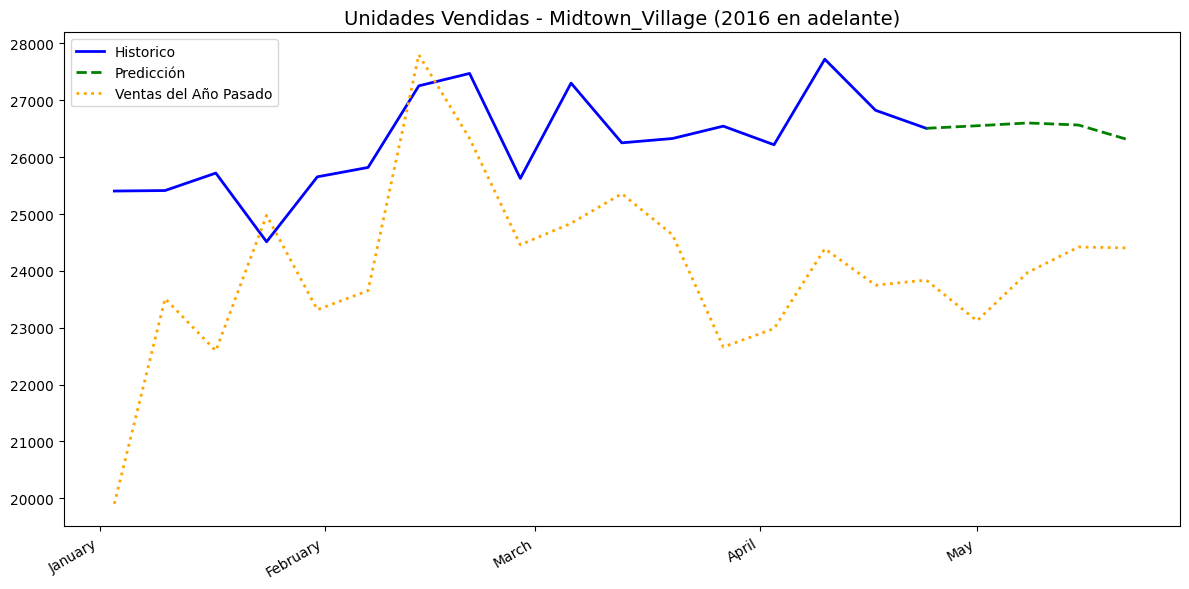

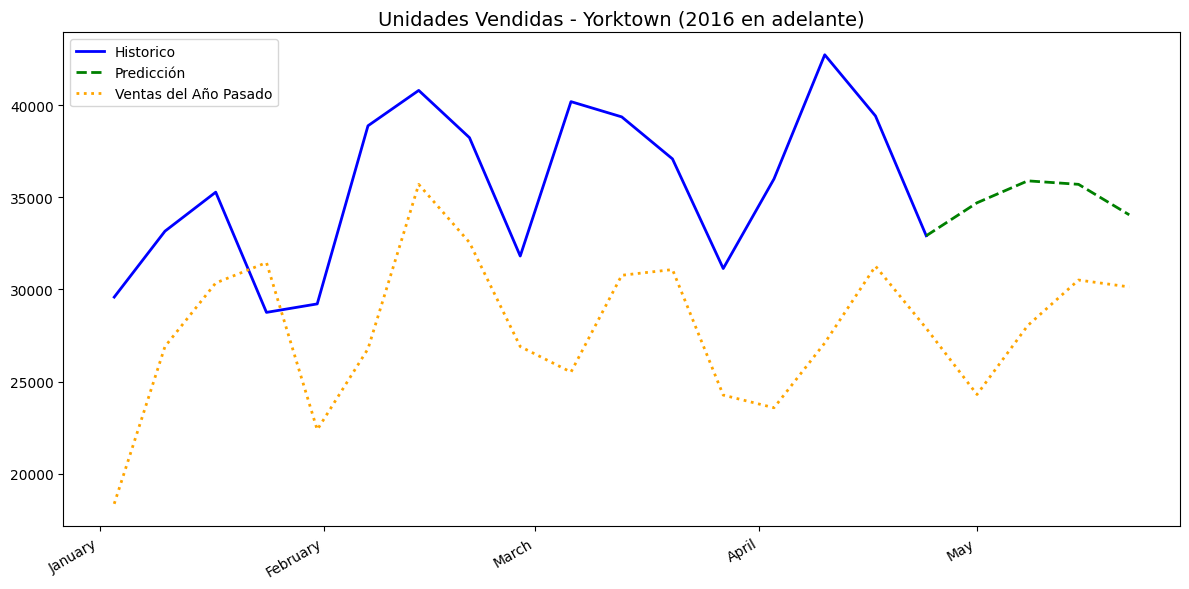

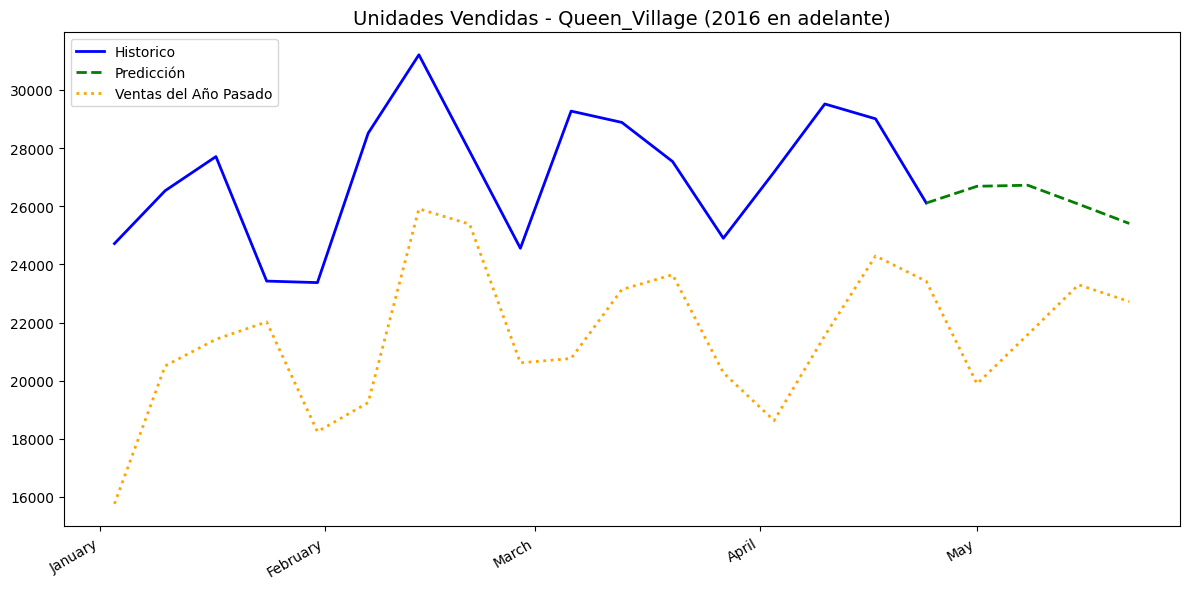

In [ ]:
plot_stores_2016_onward(df_final_org, store_list)

# Generar dataset para evaluación/visualización del stock remanente

In [ ]:
weekly_df_no_enc

,id,yearweek,date,item,category,department,store_code,store,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
0,ACCESORIES_1_001_BOS_1,201105,2011-02-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,1,4,1,5,1,1,2011
1,ACCESORIES_1_001_BOS_1,201106,2011-02-13,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,6,2,1,2011
2,ACCESORIES_1_001_BOS_1,201107,2011-02-20,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,7,2,1,2011
3,ACCESORIES_1_001_BOS_1,201108,2011-02-27,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,8,2,1,2011
4,ACCESORIES_1_001_BOS_1,201109,2011-03-06,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,0,10.968041,0,4,1,9,2,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435753,SUPERMARKET_3_827_PHI_3,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,16,4,2,2016
8435754,SUPERMARKET_3_827_PHI_3,201617,2016-05-01,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,17,4,2,2016
8435755,SUPERMARKET_3_827_PHI_3,201618,2016-05-08,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,18,5,2,2016
8435756,SUPERMARKET_3_827_PHI_3,201619,2016-05-15,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_3,Queen_Village,Philadelphia,0,1.200000,0,3,1,19,5,2,2016


## Generar datasets

In [ ]:
# Importo el dataset sin encoding para las columnas categoricas
df_train_test_1 = weekly_df_no_enc.sort_values(['yearweek','id']).reset_index(drop=True)
df_train_test_1 = df_train_test_1[df_train_test_1['yearweek'].between(201400,201616)].copy()

df_train_test_2 = weekly_df_no_enc.sort_values(['yearweek','id']).reset_index(drop=True)
df_train_test_2 = df_train_test_2[df_train_test_2['yearweek'].between(201400,201616)].copy()

df_train_test_3 = weekly_df_no_enc.sort_values(['yearweek','id']).reset_index(drop=True)
df_train_test_3 = df_train_test_3[df_train_test_3['yearweek'].between(201400,201616)].copy()

df_train_test_4 = weekly_df_no_enc.sort_values(['yearweek','id']).reset_index(drop=True)
df_train_test_4 = df_train_test_4[df_train_test_4['yearweek'].between(201400,201616)].copy()

In [ ]:
df_train_test_1

,id,yearweek,date,item,category,department,store_code,store,region,units_sold,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year
4629008,ACCESORIES_1_001_BOS_1,201401,2014-01-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_1,South_End,Boston,1,10.9858,1,4,1,1,12,4,2013
4629009,ACCESORIES_1_001_BOS_2,201401,2014-01-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_2,Roxbury,Boston,1,10.9858,1,4,1,1,12,4,2013
4629010,ACCESORIES_1_001_BOS_3,201401,2014-01-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,BOS_3,Back_Bay,Boston,0,11.1454,1,4,1,1,12,4,2013
4629011,ACCESORIES_1_001_NYC_1,201401,2014-01-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_1,Greenwich_Village,New York,2,10.9858,1,4,1,1,12,4,2013
4629012,ACCESORIES_1_001_NYC_2,201401,2014-01-05,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,NYC_2,Harlem,New York,3,10.9858,1,4,3,1,12,4,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8313937,SUPERMARKET_3_827_NYC_3,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,38,1.2000,0,3,1,16,4,2,2016
8313938,SUPERMARKET_3_827_NYC_4,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_4,Brooklyn,New York,22,1.2000,0,3,3,16,4,2,2016
8313939,SUPERMARKET_3_827_PHI_1,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia,15,1.2000,0,3,2,16,4,2,2016
8313940,SUPERMARKET_3_827_PHI_2,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia,12,1.2000,0,3,2,16,4,2,2016


In [ ]:
# La columna objetivo es 'ventas' y eliminamos 'fecha'
data_1 = df_train_test_1.drop(columns=['units_sold']).set_index('id')
y_1 = df_train_test_1.set_index('id')['units_sold']

data_2 = df_train_test_2.drop(columns=['units_sold']).set_index('id')
y_2 = df_train_test_2.set_index('id')['units_sold']

data_3 = df_train_test_3.drop(columns=['units_sold']).set_index('id')
y_3 = df_train_test_3.set_index('id')['units_sold']

data_4 = df_train_test_4.drop(columns=['units_sold']).set_index('id')
y_4 = df_train_test_4.set_index('id')['units_sold']

In [ ]:
# Dividir los datos en conjuntos de entrenamiento, validación y prueba
data_train_1, data_temp_1, y_train_1, y_temp_1 = train_test_split(data_1, y_1, test_size=0.3, shuffle=False)
data_val_1, data_test_1, y_val_1, y_test_1 = train_test_split(data_temp_1, y_temp_1, test_size=0.5, shuffle=False)

data_train_2, data_temp_2, y_train_2, y_temp_2 = train_test_split(data_2, y_2, test_size=0.3, shuffle=False)
data_val_2, data_test_2, y_val_2, y_test_2 = train_test_split(data_temp_2, y_temp_2, test_size=0.5, shuffle=False)

data_train_3, data_temp_3, y_train_3, y_temp_3 = train_test_split(data_3, y_3, test_size=0.3, shuffle=False)
data_val_3, data_test_3, y_val_3, y_test_3 = train_test_split(data_temp_3, y_temp_3, test_size=0.5, shuffle=False)

data_train_4, data_temp_4, y_train_4, y_temp_4 = train_test_split(data_4, y_4, test_size=0.3, shuffle=False)
data_val_4, data_test_4, y_val_4, y_test_4 = train_test_split(data_temp_4, y_temp_4, test_size=0.5, shuffle=False)

In [ ]:
df_test_1 = data_test_1.reset_index().join(y_test_1.reset_index()['units_sold'])
df_test_2 = data_test_2.reset_index().join(y_test_2.reset_index()['units_sold'])
df_test_3 = data_test_3.reset_index().join(y_test_3.reset_index()['units_sold'])
df_test_4 = data_test_4.reset_index().join(y_test_4.reset_index()['units_sold'])

Para calcular el stock remanente utilizo el modelo de prediccion a 2 semanas porqué en la realidad nos planteamos utilizar ese modelo para predecir la cantidad de cada item para pedir al proveedor.

In [ ]:
df_test_1_week = df_test_1.copy()
df_test_2_weeks = df_test_2.copy()
df_test_3_weeks = df_test_3.copy()
df_test_4_weeks = df_test_4.copy()

In [ ]:
len(df_test_1_week)

552741

In [ ]:
len(y_test_predictions)

4

In [ ]:
for i in range(len(y_test_predictions)):
  print(len(y_test_predictions[i]))

552741
552741
552741
552741


In [ ]:
len(df_test_2_weeks)

552741

In [ ]:
df_test_1_week['forecasted_units_sold'] = y_test_predictions[0].round(0)
df_test_2_weeks['forecasted_units_sold'] = y_test_predictions[1].round(0)
df_test_3_weeks['forecasted_units_sold'] = y_test_predictions[2].round(0)
df_test_4_weeks['forecasted_units_sold'] = y_test_predictions[3].round(0)

In [ ]:
# df_test_1_week['forecasted_units_sold'] = df_test_1_week['forecasted_units_sold'].astype(int)
# df_test_2_weeks['forecasted_units_sold'] = df_test_2_weeks['forecasted_units_sold'].astype(int)
# df_test_3_weeks['forecasted_units_sold'] = df_test_3_weeks['forecasted_units_sold'].astype(int)
# df_test_4_weeks['forecasted_units_sold'] = df_test_4_weeks['forecasted_units_sold'].astype(int)

In [ ]:
df_test_1_week

,id,yearweek,date,item,category,department,store_code,store,region,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold,forecasted_units_sold
0,SUPERMARKET_3_368_BOS_1,201551,2015-12-20,SUPERMARKET_3_368,SUPERMARKET,SUPERMARKET_3,BOS_1,South_End,Boston,7.176,0,2,1,51,12,4,2015,27,24
1,SUPERMARKET_3_368_BOS_2,201551,2015-12-20,SUPERMARKET_3_368,SUPERMARKET,SUPERMARKET_3,BOS_2,Roxbury,Boston,7.176,0,2,1,51,12,4,2015,36,32
2,SUPERMARKET_3_368_BOS_3,201551,2015-12-20,SUPERMARKET_3_368,SUPERMARKET,SUPERMARKET_3,BOS_3,Back_Bay,Boston,7.176,0,2,1,51,12,4,2015,12,15
3,SUPERMARKET_3_368_NYC_1,201551,2015-12-20,SUPERMARKET_3_368,SUPERMARKET,SUPERMARKET_3,NYC_1,Greenwich_Village,New York,7.176,0,2,1,51,12,4,2015,11,6
4,SUPERMARKET_3_368_NYC_2,201551,2015-12-20,SUPERMARKET_3_368,SUPERMARKET,SUPERMARKET_3,NYC_2,Harlem,New York,7.176,0,2,3,51,12,4,2015,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552736,SUPERMARKET_3_827_NYC_3,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.200,0,3,1,16,4,2,2016,38,47
552737,SUPERMARKET_3_827_NYC_4,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,NYC_4,Brooklyn,New York,1.200,0,3,3,16,4,2,2016,22,4
552738,SUPERMARKET_3_827_PHI_1,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_1,Midtown_Village,Philadelphia,1.200,0,3,2,16,4,2,2016,15,23
552739,SUPERMARKET_3_827_PHI_2,201616,2016-04-24,SUPERMARKET_3_827,SUPERMARKET,SUPERMARKET_3,PHI_2,Yorktown,Philadelphia,1.200,0,3,2,16,4,2,2016,12,21


In [ ]:
df_test_1_week.columns

Index(['id', 'yearweek', 'date', 'item', 'category', 'department',
       'store_code', 'store', 'region', 'price_per_unit', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year', 'units_sold', 'forecasted_units_sold'],
      dtype='object')

In [ ]:
df_test_1_week[['id', 'yearweek', 'units_sold', 'forecasted_units_sold']]

,id,yearweek,units_sold,forecasted_units_sold
0,SUPERMARKET_3_368_BOS_1,201551,27,24
1,SUPERMARKET_3_368_BOS_2,201551,36,32
2,SUPERMARKET_3_368_BOS_3,201551,12,15
3,SUPERMARKET_3_368_NYC_1,201551,11,6
4,SUPERMARKET_3_368_NYC_2,201551,17,17
...,...,...,...,...
552736,SUPERMARKET_3_827_NYC_3,201616,38,47
552737,SUPERMARKET_3_827_NYC_4,201616,22,4
552738,SUPERMARKET_3_827_PHI_1,201616,15,23
552739,SUPERMARKET_3_827_PHI_2,201616,12,21


In [ ]:
df_test_2_weeks[['id', 'yearweek', 'units_sold', 'forecasted_units_sold']]

,id,yearweek,units_sold,forecasted_units_sold
0,SUPERMARKET_3_368_BOS_1,201551,27,15
1,SUPERMARKET_3_368_BOS_2,201551,36,26
2,SUPERMARKET_3_368_BOS_3,201551,12,1
3,SUPERMARKET_3_368_NYC_1,201551,11,4
4,SUPERMARKET_3_368_NYC_2,201551,17,16
...,...,...,...,...
552736,SUPERMARKET_3_827_NYC_3,201616,38,51
552737,SUPERMARKET_3_827_NYC_4,201616,22,11
552738,SUPERMARKET_3_827_PHI_1,201616,15,27
552739,SUPERMARKET_3_827_PHI_2,201616,12,21


In [ ]:
df_test_3_weeks[['id', 'yearweek', 'units_sold', 'forecasted_units_sold']]

,id,yearweek,units_sold,forecasted_units_sold
0,SUPERMARKET_3_368_BOS_1,201551,27,15
1,SUPERMARKET_3_368_BOS_2,201551,36,23
2,SUPERMARKET_3_368_BOS_3,201551,12,3
3,SUPERMARKET_3_368_NYC_1,201551,11,3
4,SUPERMARKET_3_368_NYC_2,201551,17,15
...,...,...,...,...
552736,SUPERMARKET_3_827_NYC_3,201616,38,38
552737,SUPERMARKET_3_827_NYC_4,201616,22,14
552738,SUPERMARKET_3_827_PHI_1,201616,15,22
552739,SUPERMARKET_3_827_PHI_2,201616,12,21


In [ ]:
df_test_4_weeks[['id', 'yearweek', 'units_sold', 'forecasted_units_sold']]

,id,yearweek,units_sold,forecasted_units_sold
0,SUPERMARKET_3_368_BOS_1,201551,27,14
1,SUPERMARKET_3_368_BOS_2,201551,36,23
2,SUPERMARKET_3_368_BOS_3,201551,12,4
3,SUPERMARKET_3_368_NYC_1,201551,11,4
4,SUPERMARKET_3_368_NYC_2,201551,17,17
...,...,...,...,...
552736,SUPERMARKET_3_827_NYC_3,201616,38,51
552737,SUPERMARKET_3_827_NYC_4,201616,22,7
552738,SUPERMARKET_3_827_PHI_1,201616,15,25
552739,SUPERMARKET_3_827_PHI_2,201616,12,18


## PICKLES

In [ ]:
df_test_1_week.to_csv('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df_test_1_week.csv',index=False)
df_test_2_weeks.to_csv('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df_test_2_weeks.csv',index=False)
df_test_3_weeks.to_csv('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df_test_3_weeks.csv',index=False)
df_test_4_weeks.to_csv('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df_test_4_weeks.csv',index=False)

In [ ]:
df_test_1_week = pd.read_csv('/content/drive/MyDrive/Data Science Class/Master_DSC_Shared_Folder/DSMarket/Notebooks/Forecasting/df_test_1_week.csv')

## PLOTS DATA REAL VS FORECASTED

In [ ]:
def plot_errors(df, ts_id):
    # Asegurarse de que la columna 'date' esté en formato datetime
    df['date'] = pd.to_datetime(df['date'])

    # Filtrar el DataFrame para el ID específico
    df_filtered = df[df['id'] == ts_id]

    if df_filtered.empty:
        print(f"No data available for ID: {ts_id}")
        return

    # Agrupar por semana y sumar unidades vendidas y previstas
    df_weekly = df_filtered.resample('W', on='date').sum()

    # Extraer las series de ventas reales y previstas
    ventas_reales = df_weekly['units_sold']
    ventas_predichas = df_weekly['forecasted_units_sold']

    # Calcular el error absoluto, el error cuadrático y el RMSE
    error_absoluto = np.abs(ventas_reales - ventas_predichas)
    error_cuadratico = (ventas_reales - ventas_predichas) ** 2
    rmse = np.sqrt(np.mean(error_cuadratico))

    # Crear el gráfico principal con estilo Power BI
    plt.figure(figsize=(18, 12))

    # Colores actualizados
    color_ventas_reales = '#5cb6f9'  # Azul claro
    color_ventas_predichas = '#fbb701'  # Amarillo anaranjado

    # Graficar ventas reales y predichas
    plt.plot(df_weekly.index, ventas_reales, label="Ventas Reales", color=color_ventas_reales, marker='o', linestyle='-', linewidth=2, markersize=6)
    plt.plot(df_weekly.index, ventas_predichas, label="Ventas Pred", color=color_ventas_predichas, marker='o', linestyle='--', linewidth=2, markersize=6)

    # Área de error entre las predicciones y las ventas reales
    plt.fill_between(df_weekly.index, ventas_reales, ventas_predichas, color='gray', alpha=0.2, label="Error Absoluto")

    # Añadir RMSE en el gráfico, dentro del cuadro en la parte superior izquierda
    plt.text(df_weekly.index[0], max(ventas_reales) * 1.7, f'RMSE = {rmse:.2f}', fontsize=12, color='red', fontweight='bold')

    # Estilo del gráfico similar a Power BI
    plt.title(f"Ventas Reales vs Predicciones - {ts_id}", fontsize=16, fontweight='bold')
    plt.xlabel("Fecha", fontsize=12)
    plt.ylabel("Ventas", fontsize=12)

    # Personalizar los ejes y el fondo
    plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.gca().set_facecolor('white')  # Fondo blanco similar a Power BI
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)

    # Posicionar la leyenda en la parte superior izquierda
    plt.legend(loc='upper left', fontsize=12, frameon=False)

    # Ajustar diseño
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [ ]:
df_test_1_week['yearweek'].unique()

array([201551, 201552, 201553, 201601, 201602, 201603, 201604, 201605,
       201606, 201607, 201608, 201609, 201610, 201611, 201612, 201613,
       201614, 201615, 201616])

In [ ]:
report_df(df_test_1_week)

Shape: 552741 rows, 19 columns

--------------------------------------------------------------------------------
Columns of type Object (7):
['id', 'item', 'category', 'department', 'store_code', 'store', 'region']

--------------------------------------------------------------------------------
Columns of type Int (6):
['yearweek', 'event_week_flag', 'product_cluster', 'store_cluster', 'units_sold', 'forecasted_units_sold']

--------------------------------------------------------------------------------
Columns of type Float (1):
['price_per_unit']

--------------------------------------------------------------------------------
Columns of type Boolean (0):
[]

--------------------------------------------------------------------------------
Columns of type Datetime (1):
['date']

--------------------------------------------------------------------------------
Total missing values: 0
Total duplicate rows: 0
Min yearweek is 201551
Max yearweek is 201616
Number of ids: 30454
Number of c

In [ ]:
df_test_1_week.columns

Index(['id', 'yearweek', 'date', 'item', 'category', 'department',
       'store_code', 'store', 'region', 'price_per_unit', 'event_week_flag',
       'product_cluster', 'store_cluster', 'week_of_year', 'month', 'quarter',
       'year', 'units_sold', 'forecasted_units_sold'],
      dtype='object')

In [ ]:
df_test_1_week['category'].unique()

array(['SUPERMARKET', 'ACCESORIES', 'HOME_&_GARDEN'], dtype=object)

In [ ]:
df_test_1_week_SUPERMARKET = df_test_1_week[df_test_1_week['category'] == 'SUPERMARKET'].copy()
df_test_1_week_ACCESORIES = df_test_1_week[df_test_1_week['category'] == 'ACCESORIES'].copy()
df_test_1_week_HOME_GARDEN = df_test_1_week[df_test_1_week['category'] == 'HOME_&_GARDEN'].copy()

In [ ]:
ID_RANDOM_LIST_SUP = df_test_1_week_SUPERMARKET['id'].sample(15)
ID_RANDOM_LIST_SUP

,id
426837,SUPERMARKET_3_416_BOS_2
83068,SUPERMARKET_1_153_NYC_1
510280,SUPERMARKET_2_020_PHI_3
61730,SUPERMARKET_3_450_BOS_3
365095,SUPERMARKET_3_332_PHI_1
178520,SUPERMARKET_2_345_NYC_3
301654,SUPERMARKET_3_079_NYC_2
54398,SUPERMARKET_2_114_PHI_2
540701,SUPERMARKET_2_017_NYC_4
362824,SUPERMARKET_3_105_NYC_4


In [ ]:
ID_RANDOM_LIST_ACC = df_test_1_week_ACCESORIES['id'].sample(15)
ID_RANDOM_LIST_ACC

,id
313038,ACCESORIES_1_403_PHI_3
495318,ACCESORIES_1_359_NYC_3
431773,ACCESORIES_1_087_PHI_2
466444,ACCESORIES_2_093_NYC_3
187604,ACCESORIES_1_032_BOS_2
339967,ACCESORIES_1_041_NYC_2
37481,ACCESORIES_1_254_PHI_3
68412,ACCESORIES_1_303_NYC_4
374570,ACCESORIES_2_042_NYC_1
253006,ACCESORIES_2_067_NYC_3


In [ ]:
ID_RANDOM_LIST_HOME_GARDEN = df_test_1_week_HOME_GARDEN['id'].sample(15)
ID_RANDOM_LIST_HOME_GARDEN

,id
48602,HOME_&_GARDEN_2_266_BOS_2
166243,HOME_&_GARDEN_1_385_NYC_4
228339,HOME_&_GARDEN_1_506_NYC_2
111326,HOME_&_GARDEN_2_447_PHI_1
351752,HOME_&_GARDEN_2_125_BOS_2
439316,HOME_&_GARDEN_1_283_BOS_2
163542,HOME_&_GARDEN_1_112_NYC_1
445882,HOME_&_GARDEN_2_403_PHI_3
414271,HOME_&_GARDEN_2_288_BOS_3
533395,HOME_&_GARDEN_2_017_BOS_1


In [ ]:
for id in ID_RANDOM_LIST_SUP:
  plot_errors(df_test_1_week, ts_id = id)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for id in ID_RANDOM_LIST_ACC:
  plot_errors(df_test_1_week, ts_id = id)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for id in ID_RANDOM_LIST_HOME_GARDEN:
  plot_errors(df_test_1_week, ts_id = id)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_filtered_SUP_090 = df_test_1_week[df_test_1_week['id'] == 'SUPERMARKET_3_090_NYC_3']
df_filtered_SUP_090

,id,yearweek,date,item,category,department,store_code,store,region,price_per_unit,event_week_flag,product_cluster,store_cluster,week_of_year,month,quarter,year,units_sold,forecasted_units_sold
27679,SUPERMARKET_3_090_NYC_3,201552,2015-12-27,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.200000,1,1,1,52,12,4,2015,17,-27
58133,SUPERMARKET_3_090_NYC_3,201553,2016-01-03,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.405714,1,1,1,53,12,4,2015,6,68
88587,SUPERMARKET_3_090_NYC_3,201601,2016-01-10,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,0,1,1,1,1,1,2016,547,280
119041,SUPERMARKET_3_090_NYC_3,201602,2016-01-17,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,0,1,1,2,1,1,2016,600,731
149495,SUPERMARKET_3_090_NYC_3,201603,2016-01-24,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,0,1,1,3,1,1,2016,633,528
179949,SUPERMARKET_3_090_NYC_3,201604,2016-01-31,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,0,1,1,4,1,1,2016,599,703
210403,SUPERMARKET_3_090_NYC_3,201605,2016-02-07,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,1,1,1,5,2,1,2016,765,722
240857,SUPERMARKET_3_090_NYC_3,201606,2016-02-14,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,0,1,1,6,2,1,2016,716,716
271311,SUPERMARKET_3_090_NYC_3,201607,2016-02-21,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,0,1,1,7,2,1,2016,725,713
301765,SUPERMARKET_3_090_NYC_3,201608,2016-02-28,SUPERMARKET_3_090,SUPERMARKET,SUPERMARKET_3,NYC_3,Tribeca,New York,1.920000,0,1,1,8,2,1,2016,836,660


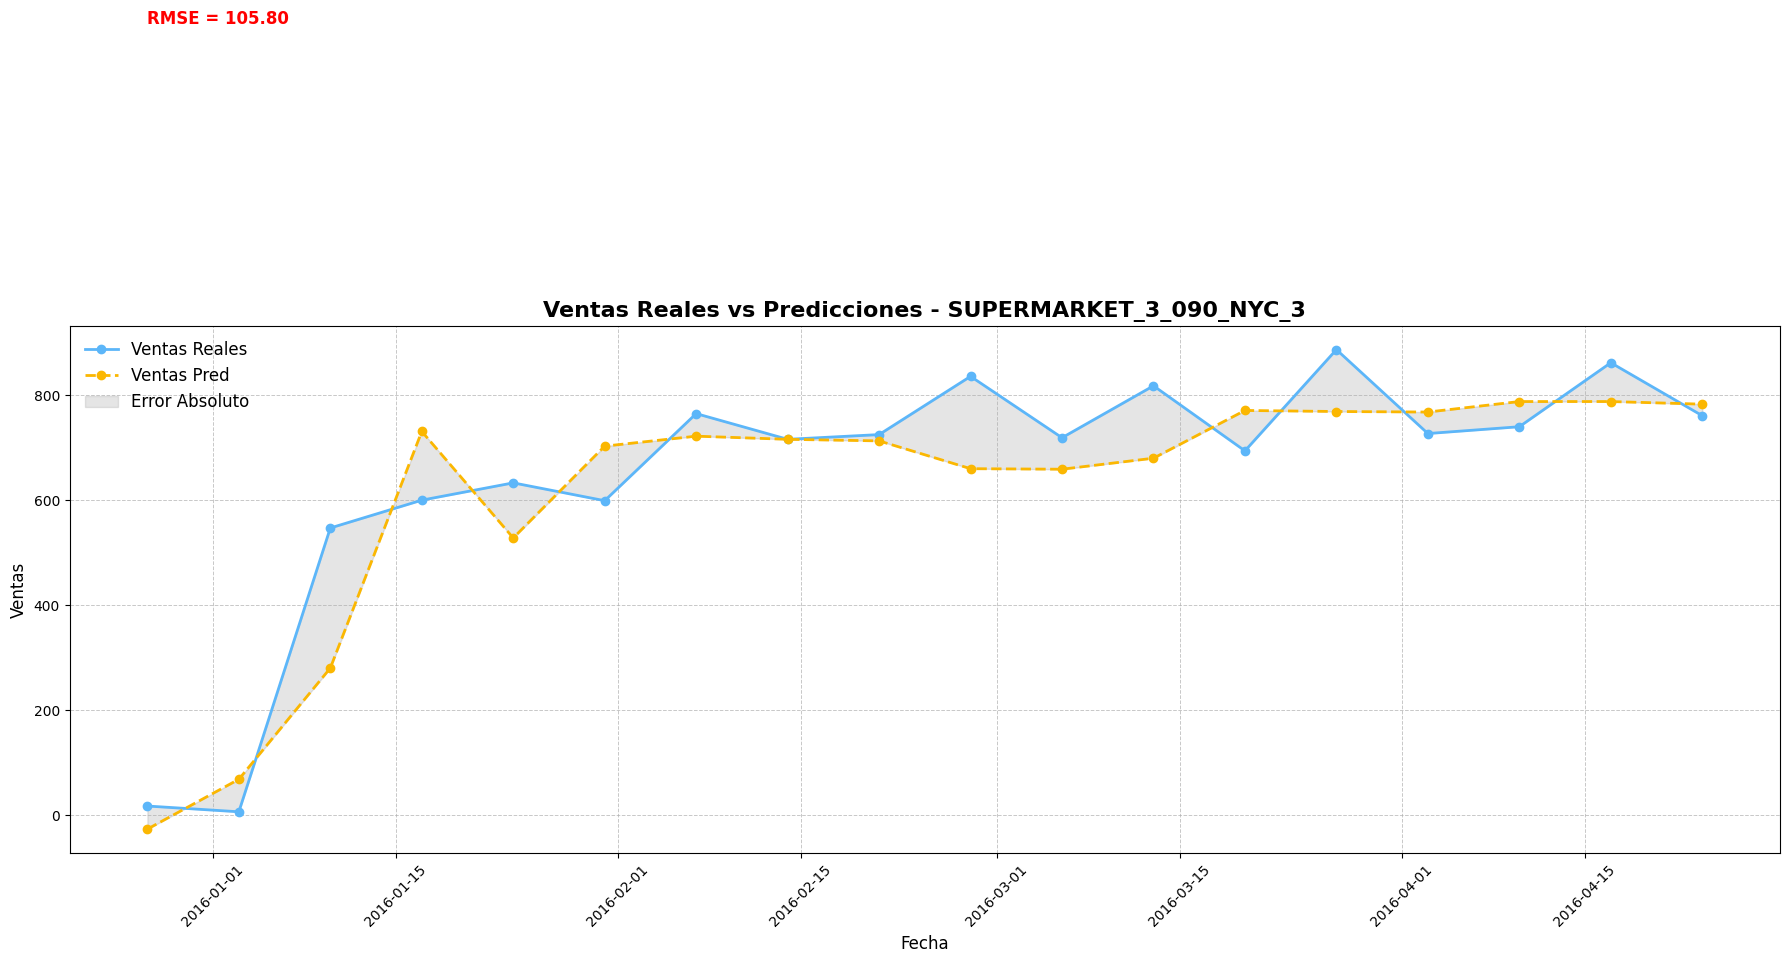

In [ ]:
plot_errors(df_test_1_week, ts_id = 'SUPERMARKET_3_090_NYC_3')